### testing

In [379]:
import pandas as pd
import folium
from branca.colormap import linear

# 假設數據
data = {
    'location': ['G1', 'G2', 'G3', 'H1', 'H2', 'H3'],
    'long': [121.54254, 121.54193, 121.54222, 121.53977, 121.53967, 121.54113],
    'lat': [25.01799, 25.01773, 25.01647, 25.01728, 25.01611, 25.0154],
    'num_cleaned_df': [10, 20, 15, 25, 30, 18],  # 物種數量
    'num_individuals': [100, 200, 150, 250, 300, 180]  # 個體數
}

# 轉換為 DataFrame
df = pd.DataFrame(data)

# 定義地圖的中心點
map_center = [25.018035617070748, 121.53815856394074]
min_lat, max_lat = 25.005,  25.027
min_lon, max_lon = 121.53, 121.545

# 創建地圖對象，使用黑白主題底圖
m = folium.Map(location=map_center, zoom_start=15.5, tiles="Cartodb Positron")

# 創建顏色映射
colormap = linear.YlOrRd_09.scale(df['num_species'].min(), df['num_species'].max())

# 將數據點添加到地圖上
for index, row in df.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['long']],
        radius=row['num_individuals'] * 0.1,  # 根據個體數調整大小
        color=colormap(row['num_species']),  # 根據物種數量調整顏色
        fill=True,
        stroke=False,
        fill_opacity=0.6,
        fill_color=colormap(row['num_species']),
        popup=f"{row['location']}: {row['num_species']}種, {row['num_individuals']}個",
    ).add_to(m)

# 在地圖上添加顏色圖例
colormap.caption = '物種數量'
colormap.add_to(m)

# 顯示地圖
# 根據數據選擇適當的圓圈大小
sizes = df['num_individuals'].quantile([0.2, 0.4, 0.6, 0.8, 1.0]).values * 0.1

template = f"""
{{% macro html(this, kwargs) %}}
<div style="
    position: fixed;
    top: 50px; 
    right: 50px; 
    width: 500px;  <!-- 增大寬度 -->
    height: 150px;
    z-index:10000;  <!-- 提高 z-index -->
    font-size:14px;
    ">
    <svg width="500" height="150">  <!-- 增大 SVG 的寬度 -->
    <text x="60" y="30" font-size="14" >Circle Sizes Legend</text>  <!-- 將文字向右移動 -->
    <circle cx="60" cy="80" r="{sizes[4]}" stroke="black" stroke-width="0" fill="gray" />  <!-- 將圓圈向右移動 -->
    <text x="{60+sizes[4]+2}" y="85" font-size="12" >{int(sizes[4]*10)}</text>
    <circle cx="145" cy="80" r="{sizes[3]}" stroke="black" stroke-width="0" fill="gray" />
    <text x="{145+sizes[3]+3}" y="85" font-size="12" >{int(sizes[3]*10)}</text>
    <circle cx="220" cy="80" r="{sizes[2]}" stroke="black" stroke-width="0" fill="gray" />
    <text x="{220 + sizes[2]+2}" y="85" font-size="12" >{int(sizes[2]*10)}</text>
    <circle cx="290" cy="80" r="{sizes[1]}" stroke="black" stroke-width="0" fill="gray" />
    <text x="{290+sizes[1]+2}" y="85" font-size="12" >{int(sizes[1]*10)}</text>
    <circle cx="350" cy="80" r="{sizes[0]}" stroke="black" stroke-width="0" fill="gray" />
    <text x="365" y="85" font-size="12" >{int(sizes[0]*10)}</text>
    </svg>
</div>
<div style="
    position: fixed;
    top: 60px;
    right: 50px;
    width: 500px;
    height: 100px;
    z-index:9999;  <!-- 降低 z-index -->
    font-size:14px;
    background-color: #ffffff;
    filter: blur(3px);
    -webkit-filter: blur(3px);
    opacity: 0.7;
    ">
</div>
{{% endmacro %}}
"""


from branca.element import Template, MacroElement
# 創建MacroElement實例並添加到地圖中
macro = MacroElement()
macro._template = Template(template)

m.get_root().add_child(macro)

# 保存或顯示地圖
m.save('map_with_legend.html')
m


In [2]:
print(df.columns)

Index(['鳥種', '數量', '距離', '結群', '備註', '組別', '樣點編號', '棲地類型\n (其他說明)', 'X座標',
       'Y座標', '調查者', '調查旅次\n編號', '天氣代號', '開始時間\n（時）', '開始時間\n（分）', '年', '月',
       '日'],
      dtype='object')


### import and clean

In [96]:
import pandas as pd
import folium
from branca.colormap import linear
df = pd.DataFrame(pd.read_csv('./data/0529bird survey_all.csv'))


# clean data
df = df[df['鳥種'] != '沒有鳥']
df = df[df['鳥種'] != '其他']
df = df.dropna(subset=['數量', '鳥種',  '樣點編號', '結群', 
                       'X座標', 'Y座標', '天氣代號',
                        '開始時間\n（時）', '開始時間\n（分）', '年', '月', '日'
                       
                          ])
df = df[~df['鳥種'].str.contains(r'[a-zA-Z]', na=False)]
# 鳥種,數量,距離,結群,備註,組別,樣點編號,"棲地類型
#  (其他說明)",X座標,Y座標,調查者,"調查旅次
# 編號",天氣代號,"開始時間
# （時）","開始時間
# （分）",年,月,日


place = df['樣點編號'].unique()
bird_species = df['鳥種'].unique()

# 總數
print(f'一共調查到 {bird_species.size} 種鳥類，分別是：')  
for i in bird_species:
    print(i, sep=',', end=',')

# 出現的鳥的資料
bird_df = pd.DataFrame({
    '鳥種名稱': bird_species,
    '數量': [df[df['鳥種'] == i]['數量'].sum() for i in bird_species],
    '樣點數': [df[df['鳥種'] == i]['樣點編號'].nunique() for i in bird_species],
    '科名' : ['' for i in bird_species] ,
    '外來種/過境/本土/特有種等等': ['' for i in bird_species]
})
bird_df.to_csv('./data/bird_species.csv', index=False)

# place_bird_num = df.groupby(['樣點編號', '鳥種'])['數量'].sum().reset_index(name='數量')
# num_birdSpecies_per_place = df.groupby('樣點編號')['鳥種'].nunique()
print(f"\n共有 {len(place)}個地點", place)


df_bird_data = pd.read_csv('./data/bird_species_info.csv')
df['科名'] = df['鳥種'].map(df_bird_data.set_index('鳥種')['科名'])
df['物種來源'] = df['鳥種'].map(df_bird_data.set_index('鳥種')['物種來源'])


df.to_csv('./data/0529bird survey_all_cleaned.csv', index=False)




一共調查到 54 種鳥類，分別是：
金背鳩,白尾八哥,紅嘴黑鵯,麻雀,夜鷺,白耳畫眉,小白鷺,家燕,斑文鳥,黑冠麻鷺,蒼鷺,喜鵲,樹鵲,紅鳩,珠頸斑鳩,白頭翁,黑領椋鳥,野鴿,大卷尾,五色鳥,大白鷺,白鶺鴒,台灣藍鵲,白面白鶺鴒,輝椋鳥,家八哥,黃頭鷺,綠繡眼,鵲鴝,灰鶺鴒,黑鳶,紅尾伯勞,八哥,灰斑鳩,灰椋鳥,綠鳩,洋燕,白頭鶇,中白鷺,白鷺鷥,白腰文鳥,翠鳥,紅冠水雞,東方黃鶺鴒,白腹秧雞,黃鸝,疣鼻棲鴨,黑天鵝,綠頭鴨,綠頭鴨(馴化),鴻雁,鸕鷀,綠頭鴨（馴化）,小卷尾,
共有 36個地點 ['B3' 'B2' 'B1' 'A1' 'A2' 'A3' 'F3' 'F2' 'F1' 'E3' 'E2' 'E1' 'I1' 'I2'
 'I3' 'J1' 'J2' 'J3' 'K1' 'K2' 'K3' 'L1' 'L2' 'L3' 'G3' 'G1' 'G2' 'H1'
 'H3' 'H2' 'C3' 'C2' 'C1' 'D1' 'D2' 'D3']


In [95]:
df

,鳥種,數量,距離,結群,備註,組別,樣點編號,棲地類型\n (其他說明),X座標,Y座標,調查者,調查旅次\n編號,天氣代號,開始時間\n（時）,開始時間\n（分）,年,月,日,科名,物種來源
0,金背鳩,1.0,A,N,NaN,1,B3,NaN,121.320500,25.010600,許家芸、吳儒杰、薛毓璇、蘇恩平、陳奕叡,1.0,B,16,40,2024,3,20,鳩鴿,特有
1,白尾八哥,1.0,A,N,NaN,1,B3,NaN,121.320500,25.010600,許家芸、吳儒杰、薛毓璇、蘇恩平、陳奕叡,1.0,B,16,40,2024,3,20,椋鳥,入侵
2,紅嘴黑鵯,1.0,A,N,NaN,1,B3,NaN,121.320500,25.010600,許家芸、吳儒杰、薛毓璇、蘇恩平、陳奕叡,1.0,B,16,40,2024,3,20,鵯,原生
3,麻雀,2.0,A,N,NaN,1,B2,NaN,121.320600,25.011000,許家芸、薛毓璇、蘇恩平、陳奕叡,1.0,B,16,53,2024,3,20,雀,原生
4,夜鷺,2.0,D,N,NaN,1,B2,NaN,121.320600,25.011000,許家芸、薛毓璇、蘇恩平、陳奕叡,1.0,B,16,53,2024,3,20,鷺,原生
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5695,野鴿,2.0,A,N,NaN,五,D1,D2,121.538039,25.020308,陳維庭、鄞甯襄、李宇喆,16.0,B,17,13,2024,5,9,鳩鴿,入侵
5696,家燕,1.0,A,N,NaN,五,D1,D2,121.538039,25.020308,陳維庭、鄞甯襄、李宇喆,16.0,B,17,13,2024,5,9,燕,原生
5697,野鴿,3.0,A,N,NaN,五,D1,D2,121.538039,25.020308,陳維庭、鄞甯襄、李宇喆,16.0,B,17,13,2024,5,9,鳩鴿,入侵
5698,小卷尾,2.0,A,N,NaN,五,D2,G2,121.538635,25.020668,陳維庭、鄞甯襄、李宇喆,16.0,B,17,23,2024,5,9,卷尾,特有


### heat map

#### 科熱圖

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
df_bird_data = pd.read_csv('./data/bird_species_info.csv')
len(df_bird_data['科名'].unique())
df_bird_data['科名'].unique()
# 使用 FontProperties 設定字體
birdfamilly_heatmap = df_bird_data.groupby(['科名'])['數量'].sum().reset_index(name='數量')
birdfamilly_heatmap

,科名,數量
0,伯勞,11
1,卷尾,47
2,擬啄木,250
3,梅花雀,23
4,椋鳥,1420
5,燕,739
6,畫眉,2
7,秧雞,84
8,繡眼,338
9,翠鳥,10


#### 非對數熱圖

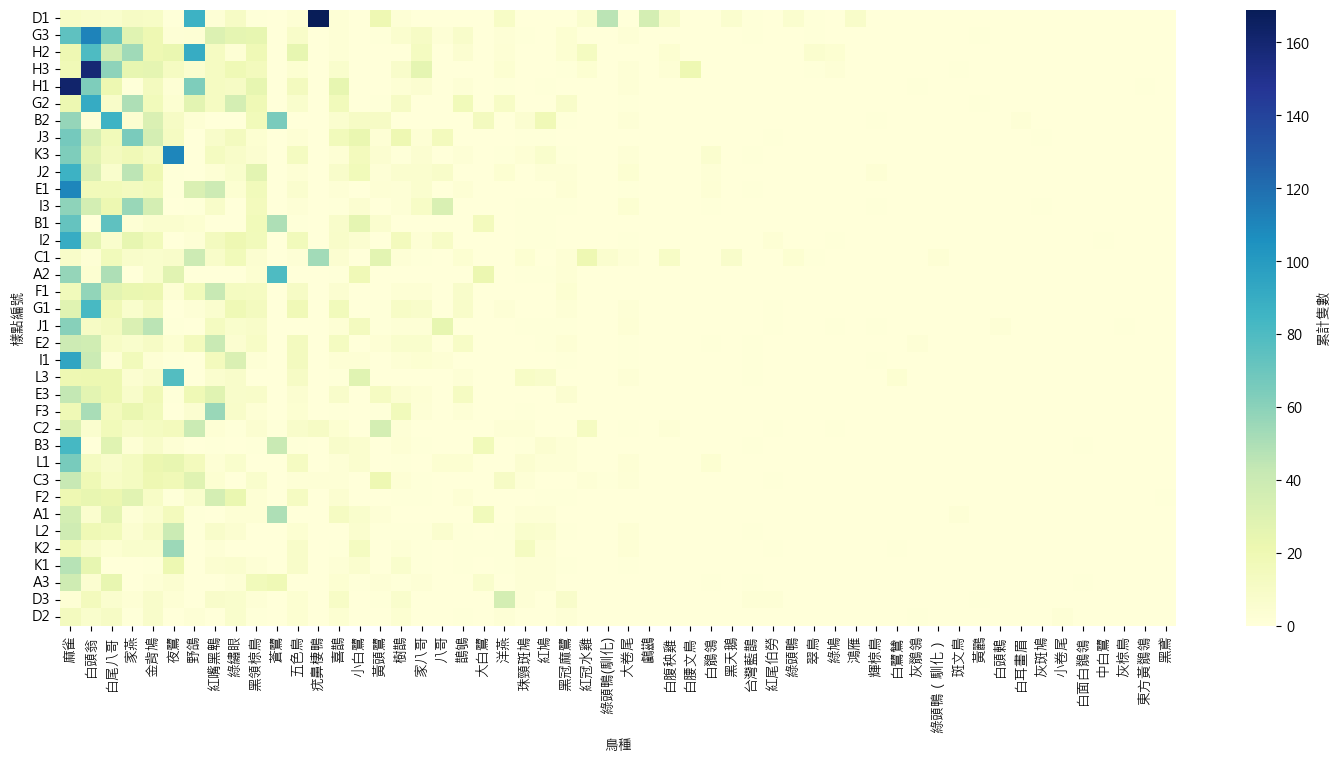

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# 使用 FontProperties 設定字體
matplotlib.rc('font', family='Microsoft JhengHei')

bird_heatmap = df.groupby(['鳥種', '樣點編號'])['數量'].sum().reset_index(name='數量')
# 創建一個以地點為行，鳥種為列，值為鳥種數量的數據框
pivot_table = bird_heatmap.pivot_table(values='數量', index='樣點編號', columns='鳥種', fill_value=0)
# 计算每种鸟的总数
bird_totals = pivot_table.sum(axis=0)
location_totals = pivot_table.sum(axis=1)

# 根据鸟的总数对列进行排序
pivot_table = pivot_table[bird_totals.sort_values(ascending=False).index]

# 根据地点的总数对行进行排序
pivot_table = pivot_table.loc[location_totals.sort_values(ascending=False).index]

# 绘制热图
plt.figure(figsize=(18, 8))
sns.heatmap(pivot_table, cmap="YlGnBu", annot=False, fmt='d', cbar_kws={'label': '累計隻數'})
plt.style.context('seaborn-whitegrid')
plt.show()

#### 早上熱圖

In [25]:
len(df[df['鳥種'] == '麻雀']['樣點編號'].unique())

36

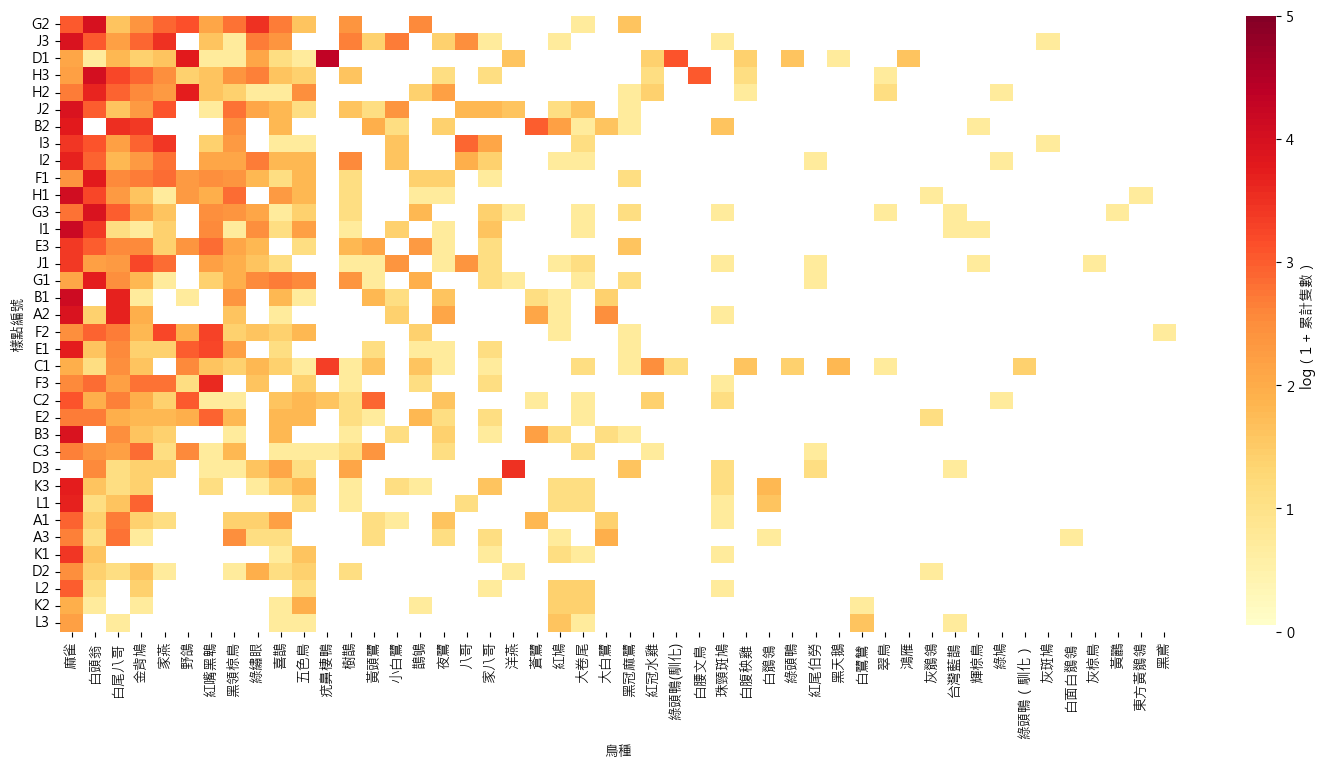

In [26]:
import numpy as np
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt

matplotlib.rcParams['axes.unicode_minus'] = False

# 早上的熱圖
morning_bird_heatmap = df[df['開始時間\n（時）'] < 12].groupby(['鳥種', '樣點編號'])['數量'].sum().reset_index(name='數量')
# 創建一個以地點為行，鳥種為列，值為鳥種數量的數據框
morning_pivot_table = morning_bird_heatmap.pivot_table(values='數量', index='樣點編號', columns='鳥種', fill_value=0)
# 计算每种鸟的总数
morning_bird_totals = morning_pivot_table.sum(axis=0)
location_totals = morning_pivot_table.sum(axis=1)

# 根据鸟的总数对列进行排序
morning_pivot_table = morning_pivot_table[morning_bird_totals.sort_values(ascending=False).index]

# 根据地点的总数对行进行排序
morning_pivot_table = morning_pivot_table.loc[location_totals.sort_values(ascending=False).index]
# 计算每种鸟的总数
morning_pivot_table_log = np.log1p(morning_pivot_table)
# pivot_table_log = pivot_table_log.replace(np.log1p(1), -10)


# 绘制热图
plt.figure(figsize=(18, 8))
cmap = ListedColormap(['white', *sns.color_palette("YlOrRd", 100)])
sns.heatmap(morning_pivot_table_log, cmap=cmap, annot=False, cbar_kws={'label': 'log（1 + 累計隻數）'}, 
            vmax=5)
plt.style.context('seaborn-whitegrid')
plt.show()

#### 下午熱圖

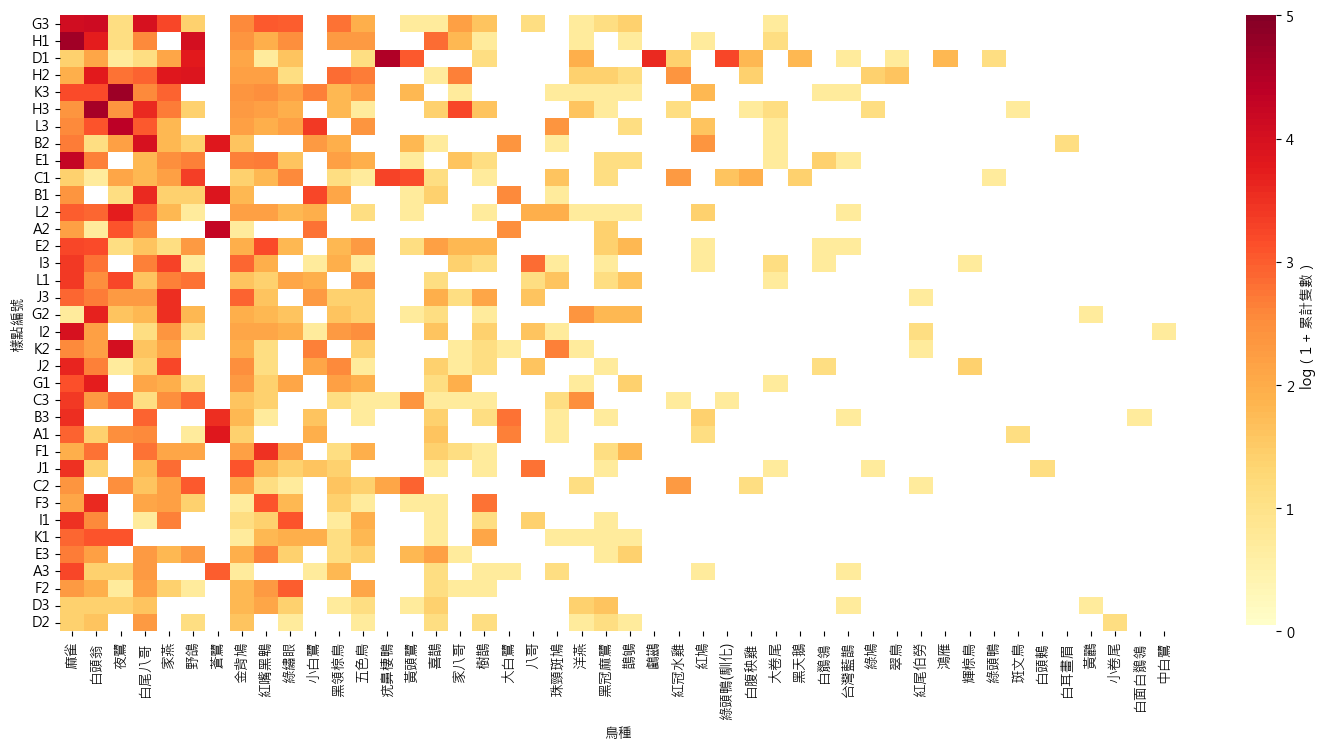

In [27]:
import numpy as np
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt

matplotlib.rcParams['axes.unicode_minus'] = False
# 下午的熱圖
noon_bird_heatmap = df[df['開始時間\n（時）'] >= 12].groupby(['鳥種', '樣點編號'])['數量'].sum().reset_index(name='數量')
# 創建一個以地點為行，鳥種為列，值為鳥種數量的數據框
noon_pivot_table = noon_bird_heatmap.pivot_table(values='數量', index='樣點編號', columns='鳥種', fill_value=0)
# 计算每种鸟的总数
noon_bird_totals = noon_pivot_table.sum(axis=0)
location_totals = noon_pivot_table.sum(axis=1)

# 根据鸟的总数对列进行排序
noon_pivot_table = noon_pivot_table[noon_bird_totals.sort_values(ascending=False).index]

# 根据地点的总数对行进行排序
noon_pivot_table = noon_pivot_table.loc[location_totals.sort_values(ascending=False).index]
# 计算每种鸟的总数
noon_pivot_table_log = np.log1p(noon_pivot_table)
# pivot_table_log = pivot_table_log.replace(np.log1p(1), -10)


# 绘制热图
plt.figure(figsize=(18, 8))
cmap = ListedColormap(['white', *sns.color_palette("YlOrRd", 100)])
sns.heatmap(noon_pivot_table_log, cmap=cmap, annot=False, cbar_kws={'label': 'log（1 + 累計隻數）'}, vmax=5)
plt.style.context('seaborn-whitegrid')
plt.show()

#### 全部熱圖

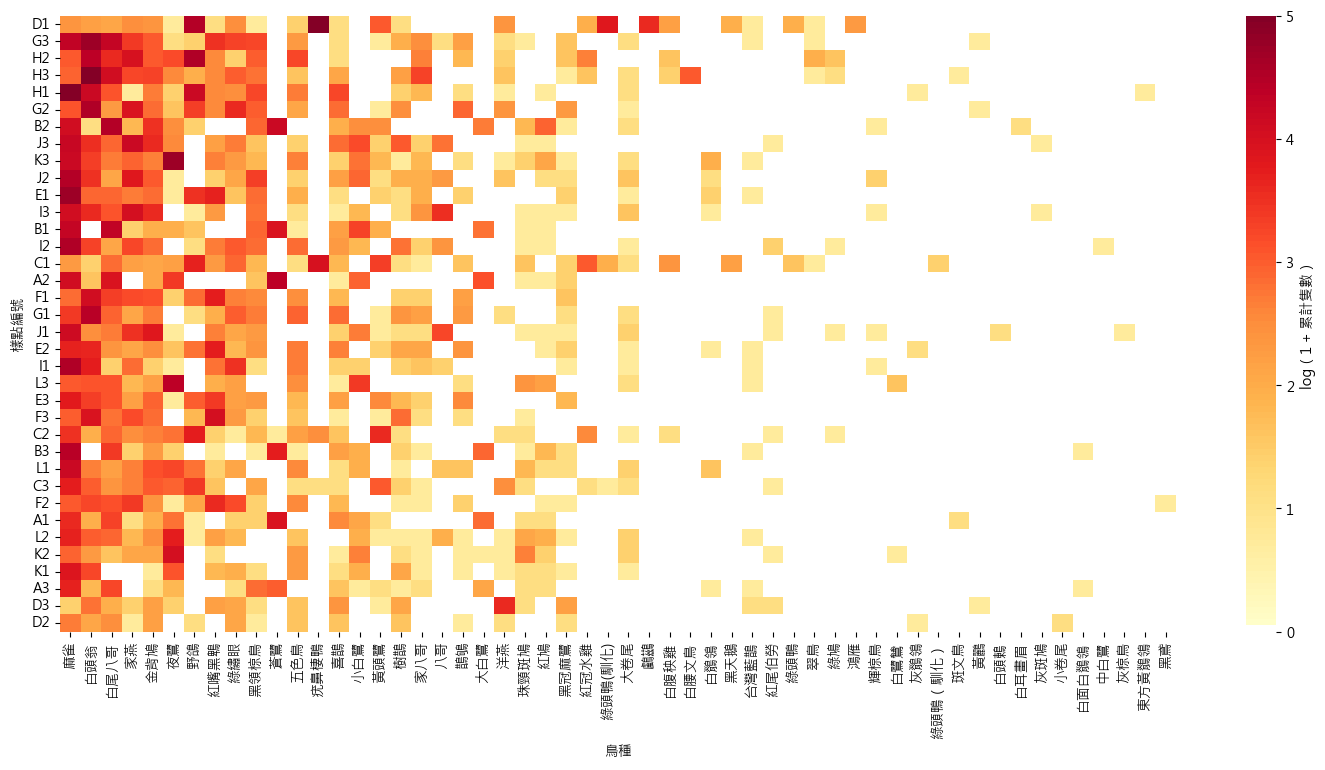

In [28]:
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt
matplotlib.rcParams['axes.unicode_minus'] = False

# 全部的熱圖
bird_heatmap = df.groupby(['鳥種', '樣點編號'])['數量'].sum().reset_index(name='數量')
# 創建一個以地點為行，鳥種為列，值為鳥種數量的數據框
pivot_table = bird_heatmap.pivot_table(values='數量', index='樣點編號', columns='鳥種', fill_value=0)
# 计算每种鸟的总数
bird_totals = pivot_table.sum(axis=0)
location_totals = pivot_table.sum(axis=1)

# 根据鸟的总数对列进行排序
pivot_table = pivot_table[bird_totals.sort_values(ascending=False).index]

# 根据地点的总数对行进行排序
pivot_table = pivot_table.loc[location_totals.sort_values(ascending=False).index]
# 计算每种鸟的总数
pivot_table_log = np.log1p(pivot_table)
# pivot_table_log = pivot_table_log.replace(np.log1p(1), -10)


# 绘制热图
plt.figure(figsize=(18, 8))
cmap = ListedColormap(['white', *sns.color_palette("YlOrRd", 100)])
sns.heatmap(pivot_table_log, cmap=cmap, annot=False, cbar_kws={'label': 'log（1 + 累計隻數）'}, vmax=5)
plt.style.context('seaborn-whitegrid')
plt.show()

#### 差異熱圖

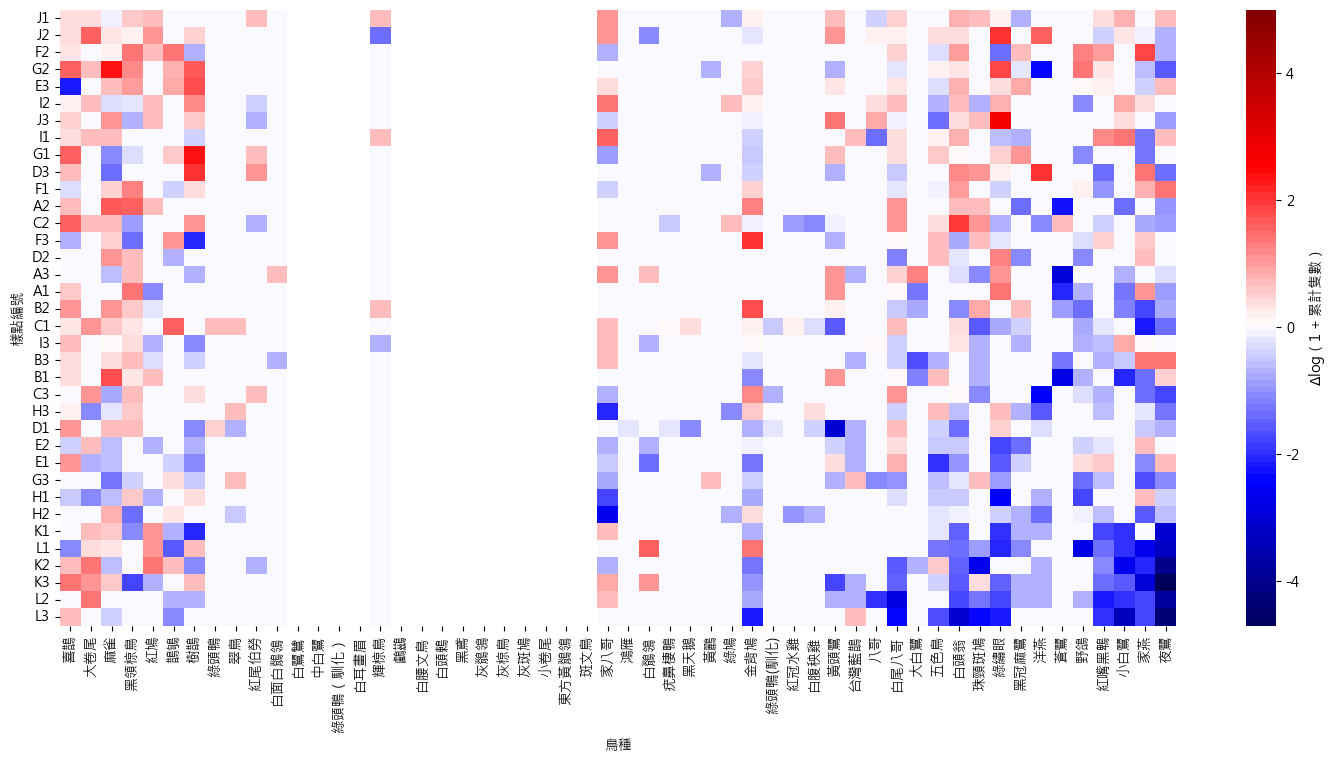

In [29]:
# 绘制热图
differ_pivot_table_log = morning_pivot_table_log - noon_pivot_table_log
# 计算每种鸟的总数
bird_totals = differ_pivot_table_log.sum(axis=0)
location_totals = differ_pivot_table_log.sum(axis=1)

# 根据鸟的总数对列进行排序
differ_pivot_table_log = differ_pivot_table_log[bird_totals.sort_values(ascending=False).index]

# 根据地点的总数对行进行排序
differ_pivot_table_log = differ_pivot_table_log.loc[location_totals.sort_values(ascending=False).index]


plt.figure(figsize=(18, 8))
cmap = ListedColormap(['white', *sns.color_palette("seismic", 100)])
sns.heatmap(differ_pivot_table_log, cmap=cmap, annot=False, cbar_kws={'label': '$\Delta$log（1 + 累計隻數）'}, 
            vmax=5, center=0)
plt.style.context('seaborn-whitegrid')
plt.show()

### Box plot & ANOVA

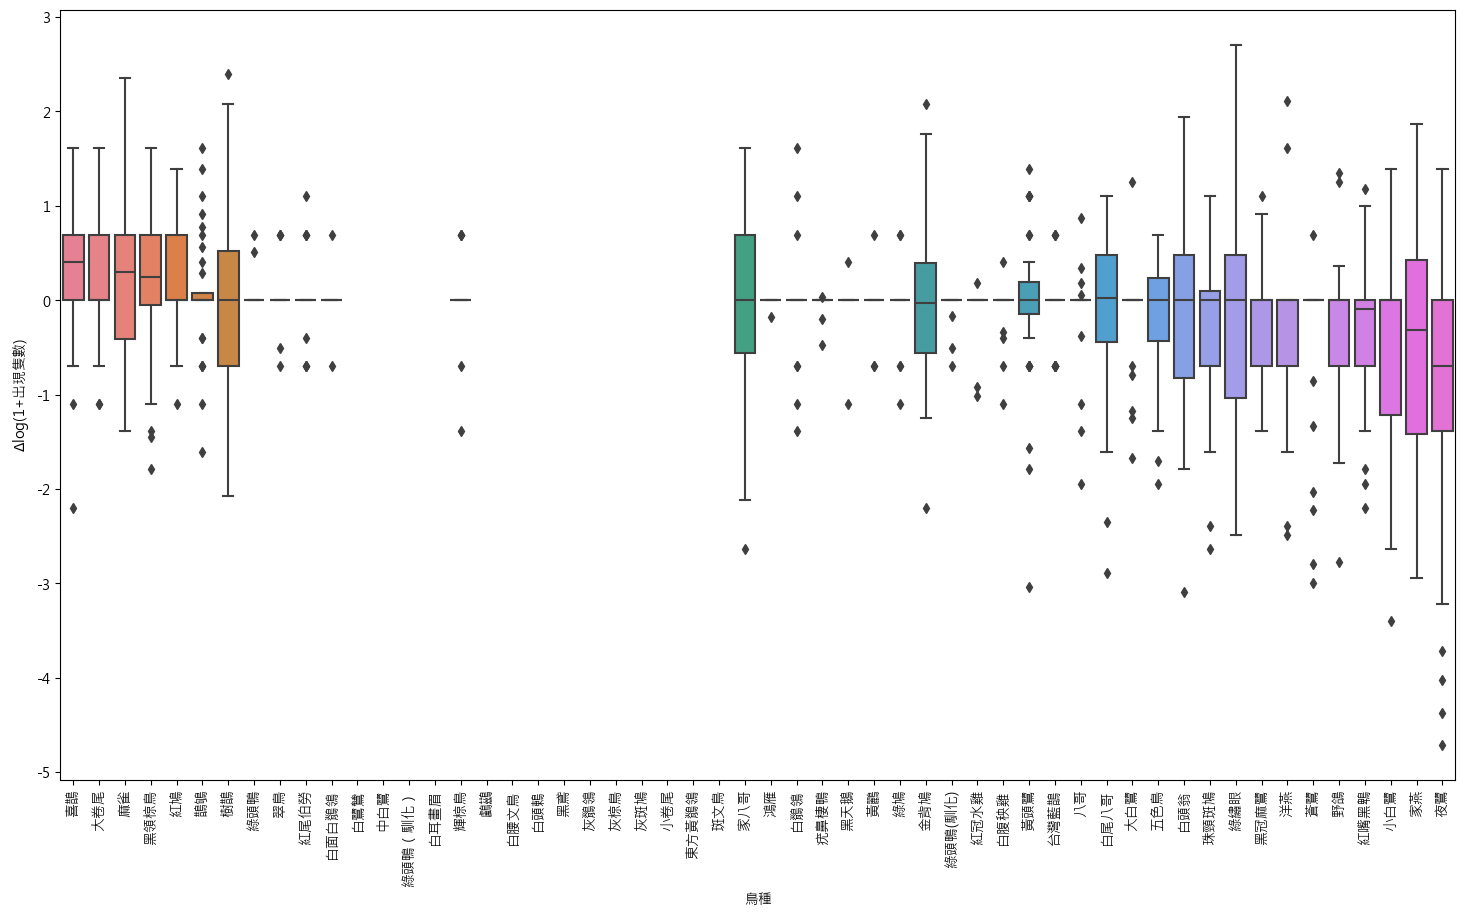

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
# 将数据框重塑为 "long format"

differ_pivot_table_log = morning_pivot_table_log - noon_pivot_table_log
colors = sns.color_palette('husl', 61)

# 计算每种鸟的总数
differ_bird_totals = differ_pivot_table_log.sum(axis=0)
location_totals = differ_pivot_table_log.sum(axis=1)

# 根据鸟的总数对列进行排序
differ_pivot_table_log = differ_pivot_table_log[differ_bird_totals.sort_values(ascending=False).index]

# 根据地点的总数对行进行排序
differ_pivot_table_log = differ_pivot_table_log.loc[location_totals.sort_values(ascending=False).index]

melted_df = pd.melt(differ_pivot_table_log.reset_index(), id_vars='樣點編號', var_name='鳥種', value_name='$\Delta$log(1+出現隻數)')

# 绘制 boxplot
plt.figure(figsize=(18, 10))
sns.boxplot(x='鳥種', y='$\Delta$log(1+出現隻數)', data=melted_df, saturation=0.75, palette=colors)

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [24]:
cleaned_df

,樣點編號,鳥種,$\Delta$log(1+出現隻數)
0,J1,喜鵲,0.405465
1,J2,喜鵲,0.405465
2,F2,喜鵲,0.287682
3,E3,喜鵲,-2.197225
4,I2,喜鵲,0.182322
...,...,...,...
2191,L1,夜鷺,-3.218876
2192,K2,夜鷺,-4.025352
2193,K3,夜鷺,-4.709530
2194,L2,夜鷺,-3.713572


In [32]:
import scipy.stats as stats

# 删除含有 NaN 的行
melted_df = pd.melt(differ_pivot_table_log.reset_index(), id_vars='樣點編號', var_name='鳥種', value_name='$\Delta$log(1+出現隻數)')
cleaned_df = melted_df.dropna(subset=['$\Delta$log(1+出現隻數)'])

# 使用 pandas 的 groupby 方法将数据按照 '鳥種' 列进行分组
grouped = cleaned_df.groupby('鳥種')

# 获取每一组的数据
groups = [grouped.get_group(name)['$\Delta$log(1+出現隻數)'] for name in grouped.groups]

# 使用 scipy 的 f_oneway 方法进行 ANOVA 测试
f_val, p_val = stats.f_oneway(*groups)

print('ANOVA test for variable $\Delta$log(1+出現隻數) among different 鳥種:')
print('F =', f_val)
print('p =', p_val)

ANOVA test for variable $\Delta$log(1+出現隻數) among different 鳥種:
F = 3.4489522357755713
p = 9.795850725402558e-12


In [33]:
# 检查每一组的数据中是否包含 NaN 值
for name, group in grouped:
    if group['$\Delta$log(1+出現隻數)'].isna().any():
        print('Group', name, 'contains NaN values')

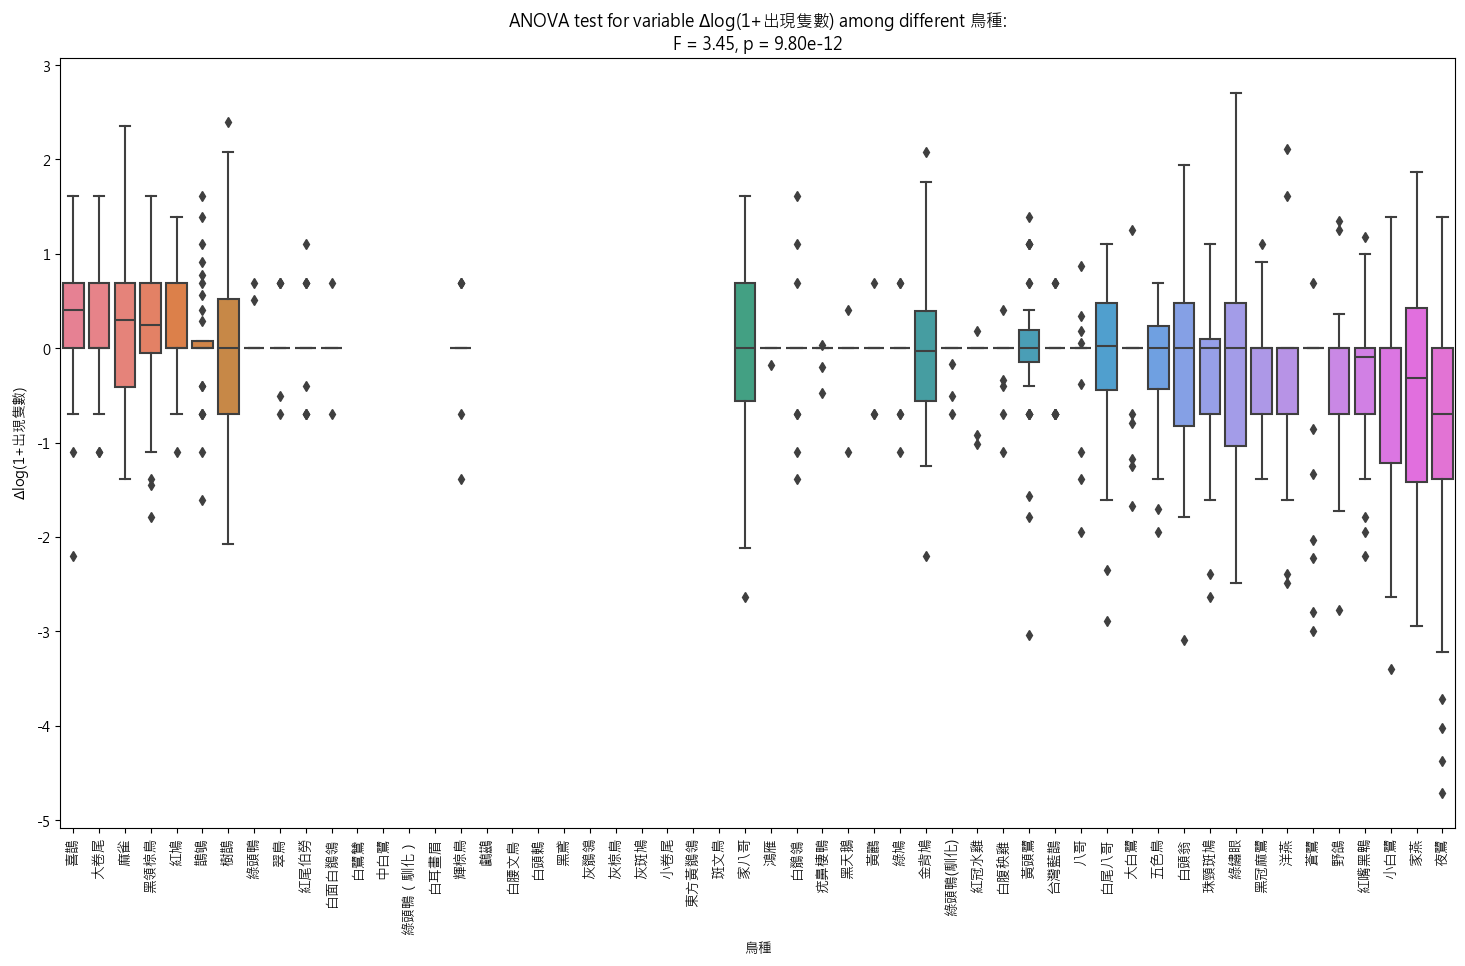

In [34]:
# 绘制 boxplot
plt.figure(figsize=(18, 10))
sns.boxplot(x='鳥種', y='$\Delta$log(1+出現隻數)', data=melted_df, saturation=0.75, palette=colors)

# 添加显著差异的结果
plt.title('ANOVA test for variable $\Delta$log(1+出現隻數) among different 鳥種:\nF = {:.2f}, p = {:.2e}'.format(f_val, p_val))

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [35]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 进行 Tukey HSD 事后检验
posthoc = pairwise_tukeyhsd(
    endog=cleaned_df['$\Delta$log(1+出現隻數)'],  # 数据
    groups=cleaned_df['鳥種'],  # 分组变量
    alpha=0.05  # 显著性水平
)

print(posthoc)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
    五色鳥      八哥   0.0739    1.0 -0.5845  0.7323  False
    五色鳥    台灣藍鵲     0.09    1.0 -0.5684  0.7484  False
    五色鳥      喜鵲   0.4951 0.5795 -0.1633  1.1535  False
    五色鳥      夜鷺  -0.7614 0.0046 -1.4198  -0.103   True
    五色鳥     大卷尾   0.4381 0.8376 -0.2203  1.0965  False
    五色鳥     大白鷺   0.0466    1.0 -0.6118   0.705  False
    五色鳥     家八哥   0.1635    1.0 -0.4949  0.8219  False
    五色鳥      家燕  -0.3281 0.9974 -0.9865  0.3303  False
    五色鳥     小白鷺  -0.2734 0.9999 -0.9318   0.385  False
    五色鳥      樹鵲   0.2025    1.0 -0.4559  0.8609  False
    五色鳥      洋燕  -0.0846    1.0  -0.743  0.5738  False
    五色鳥    珠頸斑鳩  -0.0219    1.0 -0.6803  0.6365  False
    五色鳥    疣鼻棲鴨   0.1494    1.0  -0.509  0.8078  False
    五色鳥    白尾八哥   0.0566    1.0 -0.6018   0.715  False
    五色鳥    白腹秧雞   0.1079    1.0 -0.5505  0.7663  False
    五色鳥   

#### ANOVA example code

F_onewayResult(statistic=119.26450218450468, pvalue=1.669669190769383e-31)
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

setosa vs. versicolor: Custom statistical test, P_val:1.000e-03
versicolor vs. virginica: Custom statistical test, P_val:1.000e-03
setosa vs. virginica: Custom statistical test, P_val:1.000e-03


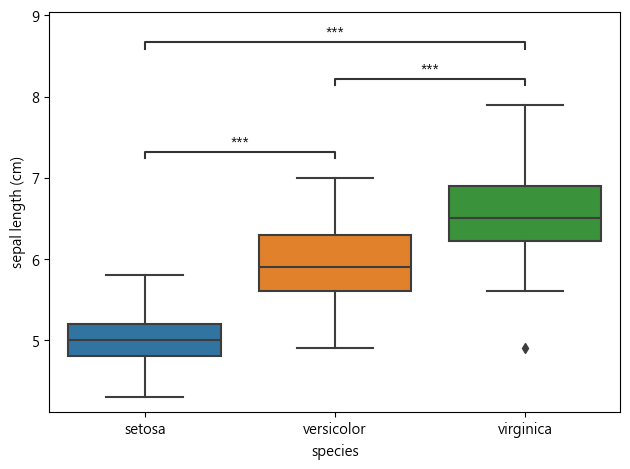

In [36]:
# test ANOVA posthoc
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

iris_obj = load_iris()
iris_df = pd.DataFrame(iris_obj.data, columns=iris_obj.feature_names)

iris_df["species"] = [iris_obj.target_names[s] for s in iris_obj.target]
iris_df.head()

species = np.unique(iris_df.species)
data = []
for s in species:
    data.append(iris_df[iris_df.species == s]["sepal length (cm)"])
from scipy import stats
stats.kruskal(*data)


from scikit_posthocs import posthoc_dunn

# posthoc dunn test, with correction for multiple testing
dunn_df = posthoc_dunn(
    iris_df, val_col="sepal length (cm)", group_col="species", p_adjust="fdr_bh"
)
dunn_df

##############################################################################3
from scikit_posthocs import posthoc_tukey

# First we do a oneway ANOVA as implemented in SciPy
print(stats.f_oneway(*data))

tukey_df = posthoc_tukey(iris_df, val_col="sepal length (cm)", group_col="species")
tukey_df

remove = np.tril(np.ones(tukey_df.shape), k=0).astype("bool")
tukey_df[remove] = np.nan

molten_df = tukey_df.melt(ignore_index=False).reset_index().dropna()
molten_df

import seaborn as sns
from statannotations.Annotator import Annotator

ax = sns.boxplot(data=iris_df, x="species", y="sepal length (cm)", order=species)

pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_df.iterrows()]
p_values = [i[1]["value"] for i in molten_df.iterrows()]

annotator = Annotator(
    ax, pairs, data=iris_df, x="species", y="sepal length (cm)", order=species
)
annotator.configure(text_format="star", loc="inside")
annotator.set_pvalues_and_annotate(p_values)

plt.tight_layout()

#### Log 版本 ANOVA posthoc

In [227]:
significant_pairs

[('喜鵲', '紅嘴黑鵯'),
 ('喜鵲', '斯氏繡眼'),
 ('喜鵲', '小白鷺'),
 ('喜鵲', '家燕'),
 ('大卷尾', '家燕'),
 ('麻雀', '家燕'),
 ('喜鵲', '夜鷺'),
 ('大卷尾', '夜鷺'),
 ('麻雀', '夜鷺'),
 ('黑領椋鳥', '夜鷺'),
 ('綠繡眼', '夜鷺'),
 ('紅鳩', '夜鷺'),
 ('XX燕', '夜鷺'),
 ('鵲鴝', '夜鷺'),
 ('樹鵲', '夜鷺'),
 ('綠頭鴨', '夜鷺'),
 ('翠鳥', '夜鷺'),
 ('紅尾伯勞', '夜鷺'),
 ('XX鷺', '夜鷺'),
 ('白面白鶺鴒', '夜鷺'),
 ('輝椋鳥', '夜鷺'),
 ('家八哥', '夜鷺'),
 ('鴻雁', '夜鷺'),
 ('白鶺鴒', '夜鷺'),
 ('疣鼻棲鴨', '夜鷺'),
 ('黑天鵝', '夜鷺'),
 ('黃鸝', '夜鷺'),
 ('綠鳩', '夜鷺'),
 ('金背鳩', '夜鷺'),
 ('綠頭鴨(馴化)', '夜鷺'),
 ('紅冠水雞', '夜鷺'),
 ('白腹秧雞', '夜鷺'),
 ('黃頭鷺', '夜鷺'),
 ('台灣藍鵲', '夜鷺'),
 ('八哥', '夜鷺'),
 ('XX鳩鴿', '夜鷺'),
 ('XX八哥', '夜鷺'),
 ('白尾八哥', '夜鷺'),
 ('大白鷺', '夜鷺'),
 ('五色鳥', '夜鷺'),
 ('白頭翁', '夜鷺'),
 ('珠頸斑鳩', '夜鷺')]

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

綠繡眼 vs. 夜鷺: Custom statistical test, P_val:9.928e-03
珠頸斑鳩 vs. 夜鷺: Custom statistical test, P_val:7.944e-03
白頭翁 vs. 夜鷺: Custom statistical test, P_val:7.487e-03
五色鳥 vs. 夜鷺: Custom statistical test, P_val:4.569e-03
大白鷺 vs. 夜鷺: Custom statistical test, P_val:1.311e-03
白尾八哥 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
八哥 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
台灣藍鵲 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
黃頭鷺 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
白腹秧雞 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
紅冠水雞 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
綠頭鴨(馴化) vs. 夜鷺: Custom statistical test, P_val:1.000e-03
金背鳩 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
綠鳩 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
黃鸝 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
黑天鵝 vs.

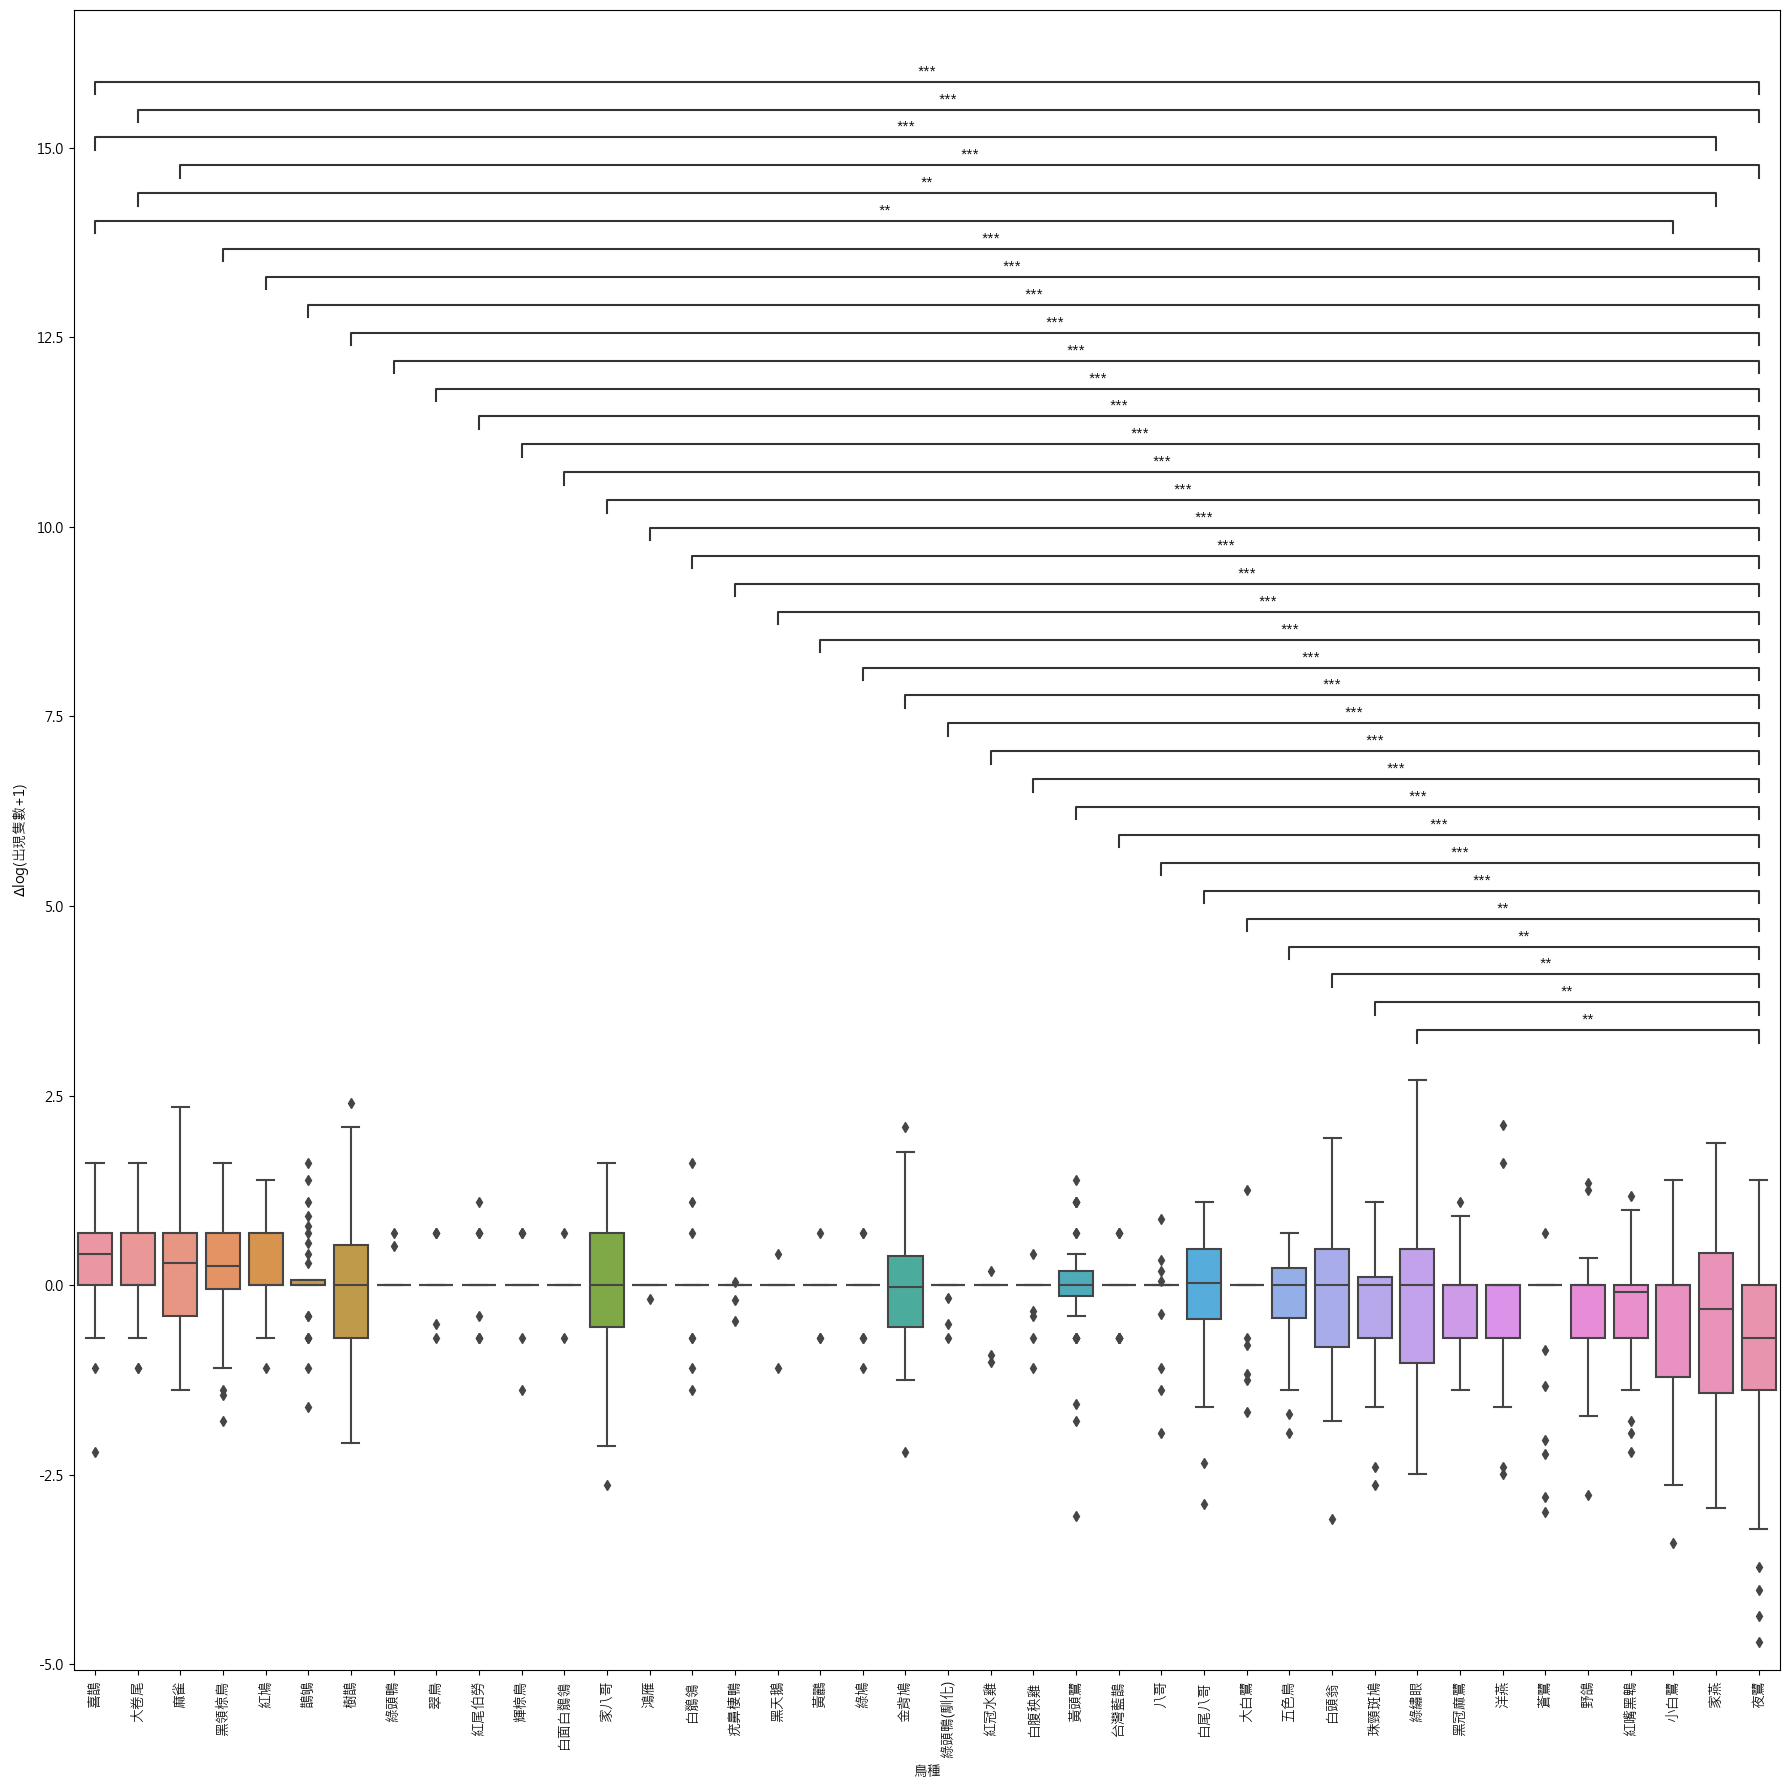

In [85]:
from scikit_posthocs import posthoc_tukey

y_label = "$\Delta$log(出現隻數+1)"
x_label = "鳥種"

melted_df = pd.melt(differ_pivot_table_log.reset_index(), id_vars='樣點編號', var_name=x_label, value_name=y_label)
cleaned_df = melted_df.dropna(subset=[y_label])



# First we do a oneway ANOVA as implemented in SciPy
# print(stats.f_oneway(*data))
tukey_df = posthoc_tukey(cleaned_df, val_col=y_label, group_col=x_label)
tukey_df

remove = np.tril(np.ones(tukey_df.shape), k=0).astype("bool")
tukey_df[remove] = np.nan

molten_df = tukey_df.melt(ignore_index=False).reset_index().dropna()
molten_df

#############################3
import seaborn as sns
from statannotations.Annotator import Annotator



bird_sum = cleaned_df.groupby(x_label)[y_label].sum()
bird_sorted = bird_sum.sort_values(ascending=False)

plt.figure(figsize=(18, 18))
species = bird_sorted.index
ax = sns.boxplot(data=cleaned_df, x=x_label, y=y_label, order=species)
plt.xticks(rotation=90)
# 设置显著性水平
alpha = 0.01

# 计算 p 值
pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_df.iterrows()]
p_values = [i[1]["value"] for i in molten_df.iterrows()]

# 只保留 p 值小于 alpha 的组别
significant_pairs = [pair for pair, p in zip(pairs, p_values) if p < alpha]
significant_p_values = [p for p in p_values if p < alpha]

# 创建 Annotator 对象
annotator = Annotator(
    ax, significant_pairs, data=cleaned_df, x=x_label, y=y_label, order=species
)

# 配置 Annotator 对象
annotator.configure(text_format="star", loc="inside")

# 设置 p 值并添加标记
annotator.set_pvalues_and_annotate(significant_p_values)

plt.tight_layout()


#### 一般版本 ANOVA

In [141]:
significant_pairs

[('XX八哥', '夜鷺'),
 ('XX燕', '夜鷺'),
 ('XX鳩鴿', '夜鷺'),
 ('XX鷺', '夜鷺'),
 ('五色鳥', '夜鷺'),
 ('八哥', '夜鷺'),
 ('台灣藍鵲', '夜鷺'),
 ('喜鵲', '夜鷺'),
 ('夜鷺', '大卷尾'),
 ('夜鷺', '大白鷺'),
 ('夜鷺', '家八哥'),
 ('夜鷺', '家燕'),
 ('夜鷺', '小白鷺'),
 ('夜鷺', '斯氏繡眼'),
 ('夜鷺', '樹鵲'),
 ('夜鷺', '洋燕'),
 ('夜鷺', '珠頸斑鳩'),
 ('夜鷺', '疣鼻棲鴨'),
 ('夜鷺', '白尾八哥'),
 ('夜鷺', '白腹秧雞'),
 ('夜鷺', '白面白鶺鴒'),
 ('夜鷺', '白頭翁'),
 ('夜鷺', '白鶺鴒'),
 ('夜鷺', '紅冠水雞'),
 ('夜鷺', '紅嘴黑鵯'),
 ('夜鷺', '紅尾伯勞'),
 ('夜鷺', '紅鳩'),
 ('夜鷺', '綠繡眼'),
 ('夜鷺', '綠頭鴨'),
 ('夜鷺', '綠頭鴨(馴化)'),
 ('夜鷺', '綠鳩'),
 ('夜鷺', '翠鳥'),
 ('喜鵲', '蒼鷺'),
 ('夜鷺', '輝椋鳥'),
 ('夜鷺', '野鴿'),
 ('夜鷺', '金背鳩'),
 ('蒼鷺', '金背鳩'),
 ('夜鷺', '鴻雁'),
 ('夜鷺', '鵲鴝'),
 ('夜鷺', '麻雀'),
 ('家燕', '麻雀'),
 ('蒼鷺', '麻雀'),
 ('夜鷺', '黃頭鷺'),
 ('夜鷺', '黃鸝'),
 ('夜鷺', '黑冠麻鷺'),
 ('夜鷺', '黑天鵝'),
 ('夜鷺', '黑領椋鳥'),
 ('蒼鷺', '黑領椋鳥')]

In [140]:
significant_p_values

[0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.0013702575984279042,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.0032994033195787864,
 0.001,
 0.001,
 0.001,
 0.005641314148496668,
 0.001,
 0.001,
 0.001,
 0.008785428720685884,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.005228847603720332]

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

家燕 vs. 夜鷺: Custom statistical test, P_val:3.897e-03
小白鷺 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
白頭翁 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
野鴿 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
白尾八哥 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
五色鳥 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
大白鷺 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
黃頭鷺 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
紅嘴黑鵯 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
家八哥 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
珠頸斑鳩 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
疣鼻棲鴨 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
綠繡眼 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
黑冠麻鷺 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
紅冠水雞 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
綠頭鴨(馴化) v

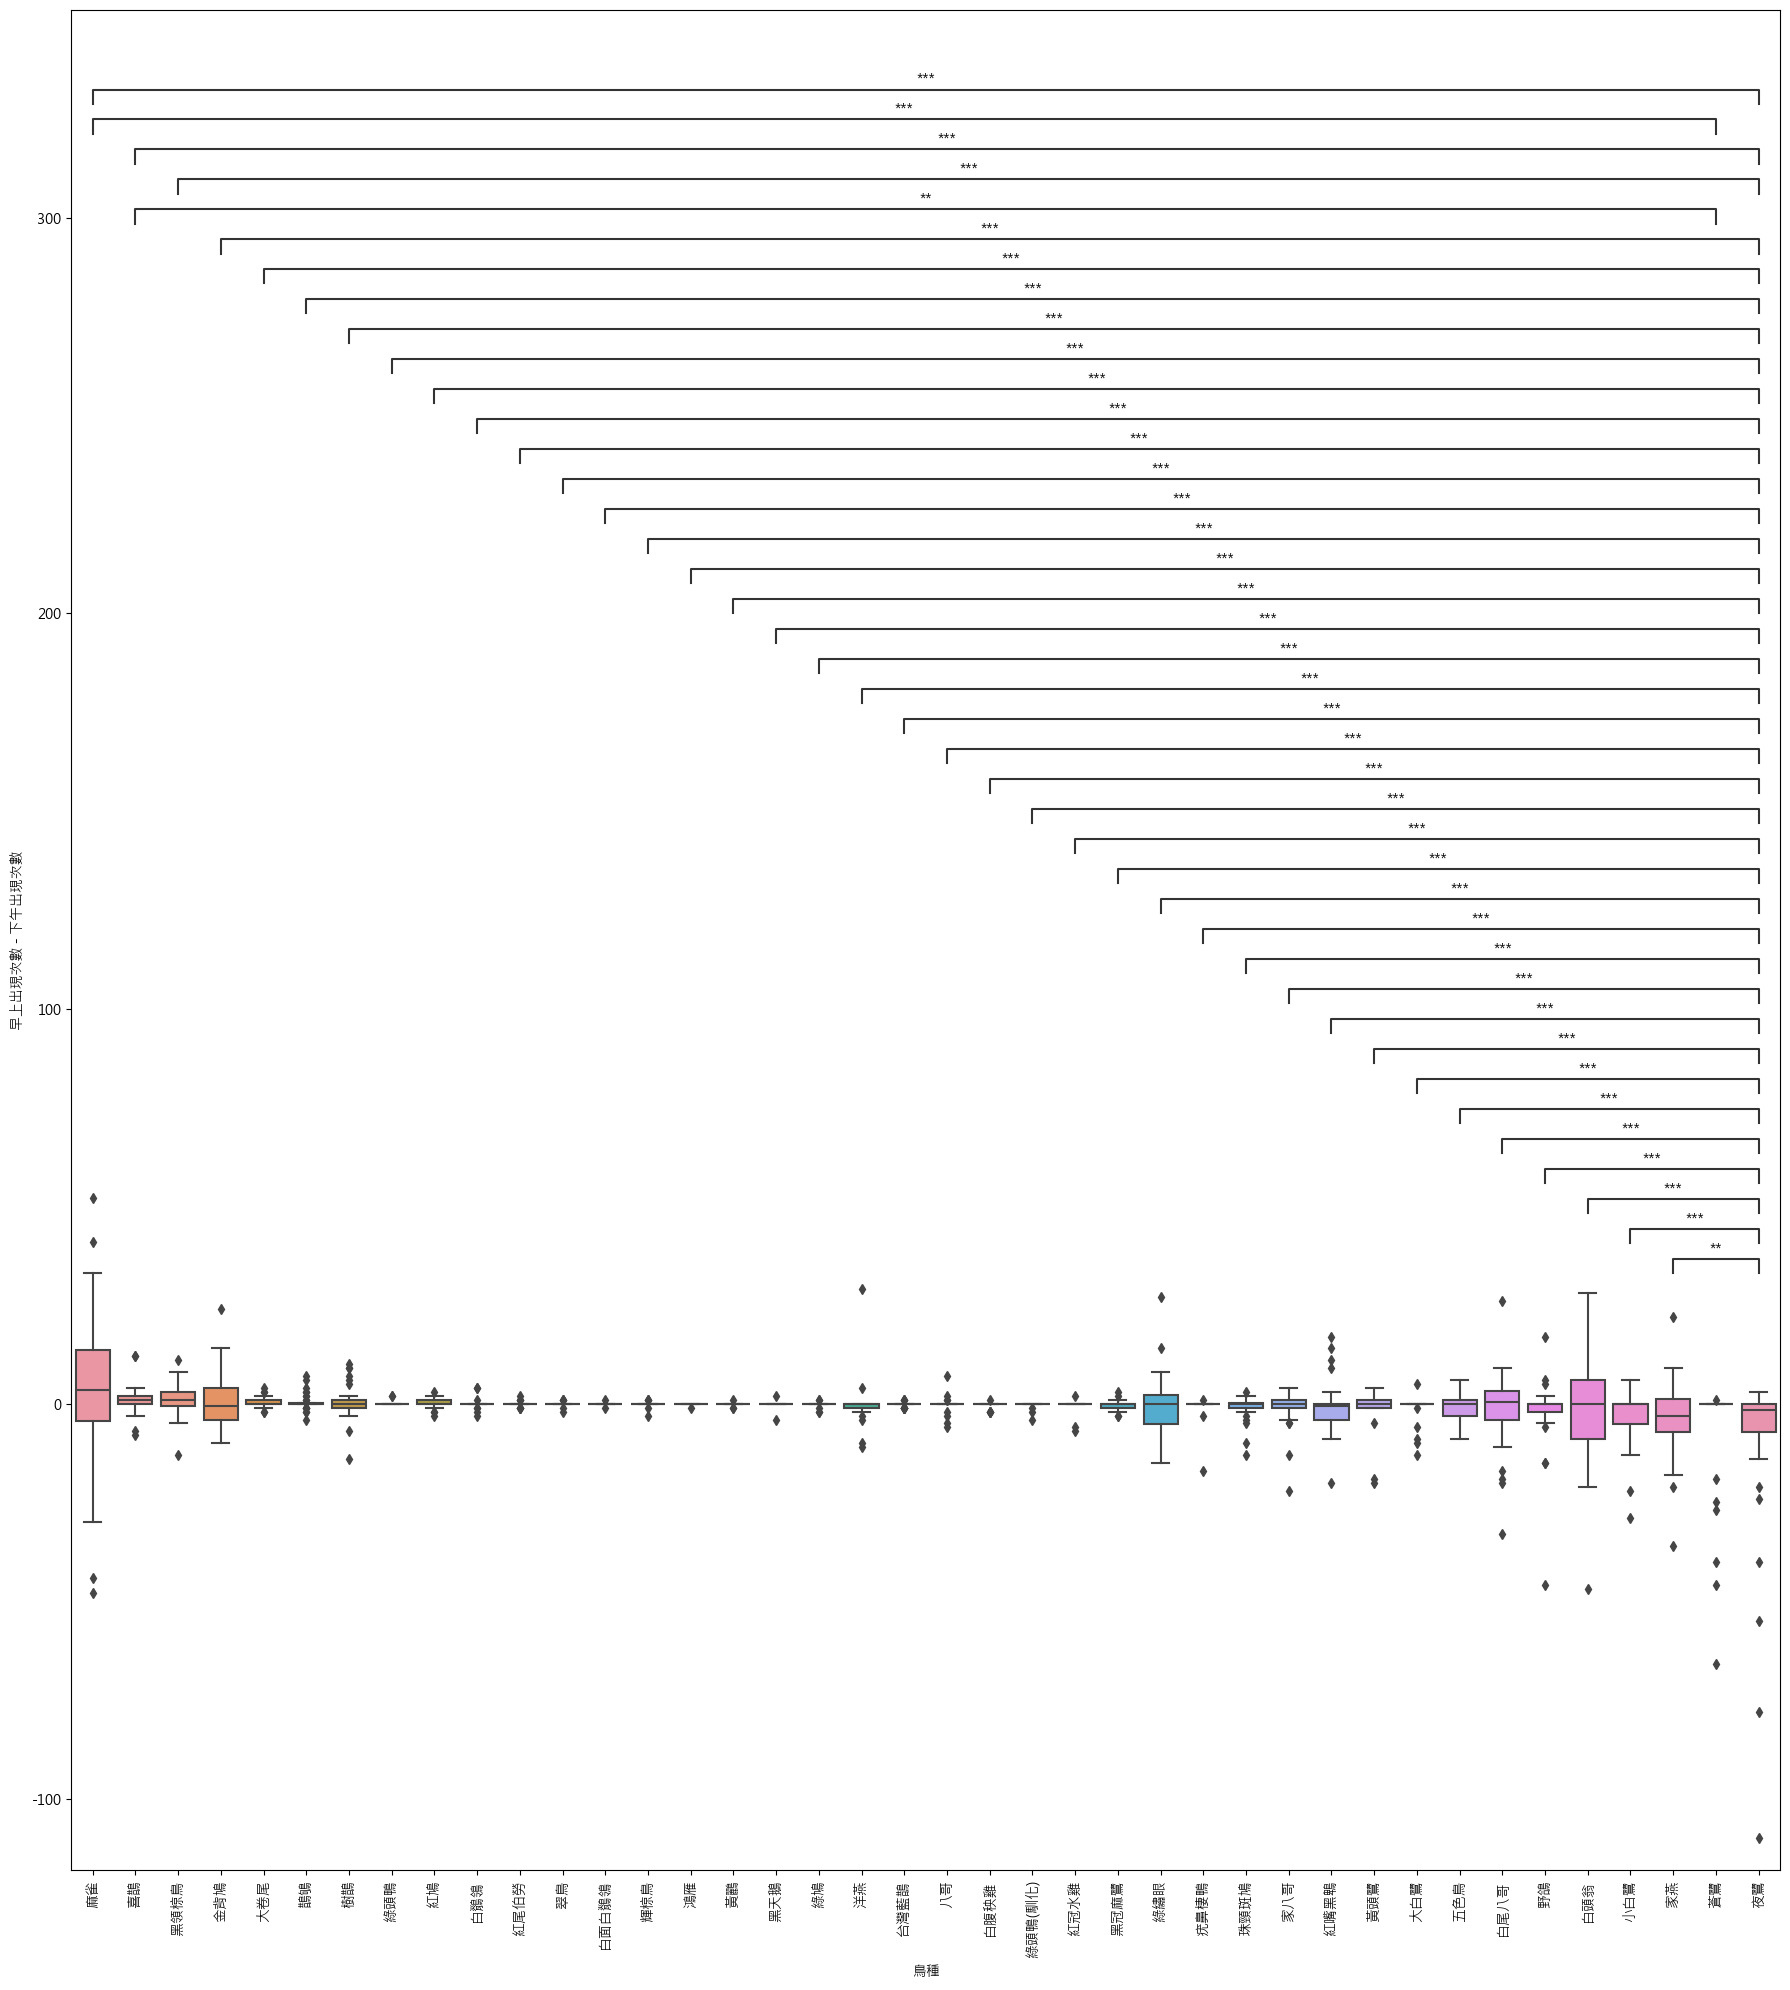

In [86]:
from scikit_posthocs import posthoc_tukey

differ_pivot_table = (morning_pivot_table - noon_pivot_table)
import math
'''
如果 (morning_pivot_table - noon_pivot_table)/pivot_table 就會全部都不顯著 都會介於 -1 ~ 1 之間

'''
# differ_pivot_table = differ_pivot_table.applymap(lambda x: math.log(x+0.001))
y_label = "早上出現次數 - 下午出現次數"
x_label = "鳥種"

# 要沒有 log 版本
melted_df = pd.melt(differ_pivot_table.reset_index(), id_vars='樣點編號', var_name=x_label, value_name=y_label)
cleaned_df = melted_df.dropna(subset=[y_label])


# First we do a oneway ANOVA as implemented in SciPy
# print(stats.f_oneway(*data))
tukey_df = posthoc_tukey(cleaned_df, val_col=y_label, group_col=x_label)
tukey_df

remove = np.tril(np.ones(tukey_df.shape), k=0).astype("bool")
tukey_df[remove] = np.nan

molten_df = tukey_df.melt(ignore_index=False).reset_index().dropna()
molten_df

#############################3
import seaborn as sns
from statannotations.Annotator import Annotator



bird_sum = cleaned_df.groupby(x_label)[y_label].sum()
bird_sorted = bird_sum.sort_values(ascending=False)

plt.figure(figsize=(18, 20))
species = bird_sorted.index
ax = sns.boxplot(data=cleaned_df, x=x_label, y=y_label, order=species)
plt.xticks(rotation=90)
# 设置显著性水平
alpha = 0.01

# 计算 p 值
pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_df.iterrows()]
p_values = [i[1]["value"] for i in molten_df.iterrows()]

# 只保留 p 值小于 alpha 的组别
significant_pairs = [pair for pair, p in zip(pairs, p_values) if p < alpha]
significant_p_values = [p for p in p_values if p < alpha]

# 创建 Annotator 对象
annotator = Annotator(
    ax, significant_pairs, data=cleaned_df, x=x_label, y=y_label, order=species
)

# 配置 Annotator 对象
annotator.configure(text_format="star", loc="inside")

# 设置 p 值并添加标记
annotator.set_pvalues_and_annotate(significant_p_values)

plt.tight_layout()


In [238]:
selected_df

,樣點編號,鳥種,$\Delta$log(出現隻數+1)
0,J1,喜鵲,0.405465
1,J2,喜鵲,0.405465
2,F2,喜鵲,0.287682
3,E3,喜鵲,-2.197225
4,I2,喜鵲,0.182322
...,...,...,...
2191,L1,夜鷺,-3.218876
2192,K2,夜鷺,-4.025352
2193,K3,夜鷺,-4.709530
2194,L2,夜鷺,-3.713572


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

大卷尾 vs. 紅嘴黑鵯: Custom statistical test, P_val:3.374e-02
綠繡眼 vs. 家燕: Custom statistical test, P_val:4.353e-02
喜鵲 vs. 紅嘴黑鵯: Custom statistical test, P_val:8.446e-03
大卷尾 vs. 斯氏繡眼: Custom statistical test, P_val:2.308e-02
麻雀 vs. 小白鷺: Custom statistical test, P_val:3.578e-02
黑領椋鳥 vs. 家燕: Custom statistical test, P_val:2.435e-02
綠繡眼 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
喜鵲 vs. 斯氏繡眼: Custom statistical test, P_val:5.500e-03
大卷尾 vs. 小白鷺: Custom statistical test, P_val:1.028e-02
麻雀 vs. 家燕: Custom statistical test, P_val:9.568e-03
黑領椋鳥 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
喜鵲 vs. 小白鷺: Custom statistical test, P_val:2.222e-03
大卷尾 vs. 家燕: Custom statistical test, P_val:2.371e-03
麻雀 vs. 夜鷺: Custom statistical test, P_val:1.000e-03
喜鵲 vs. 家燕: Custom statistical test, P_val:1.000e-03
大卷尾 vs.

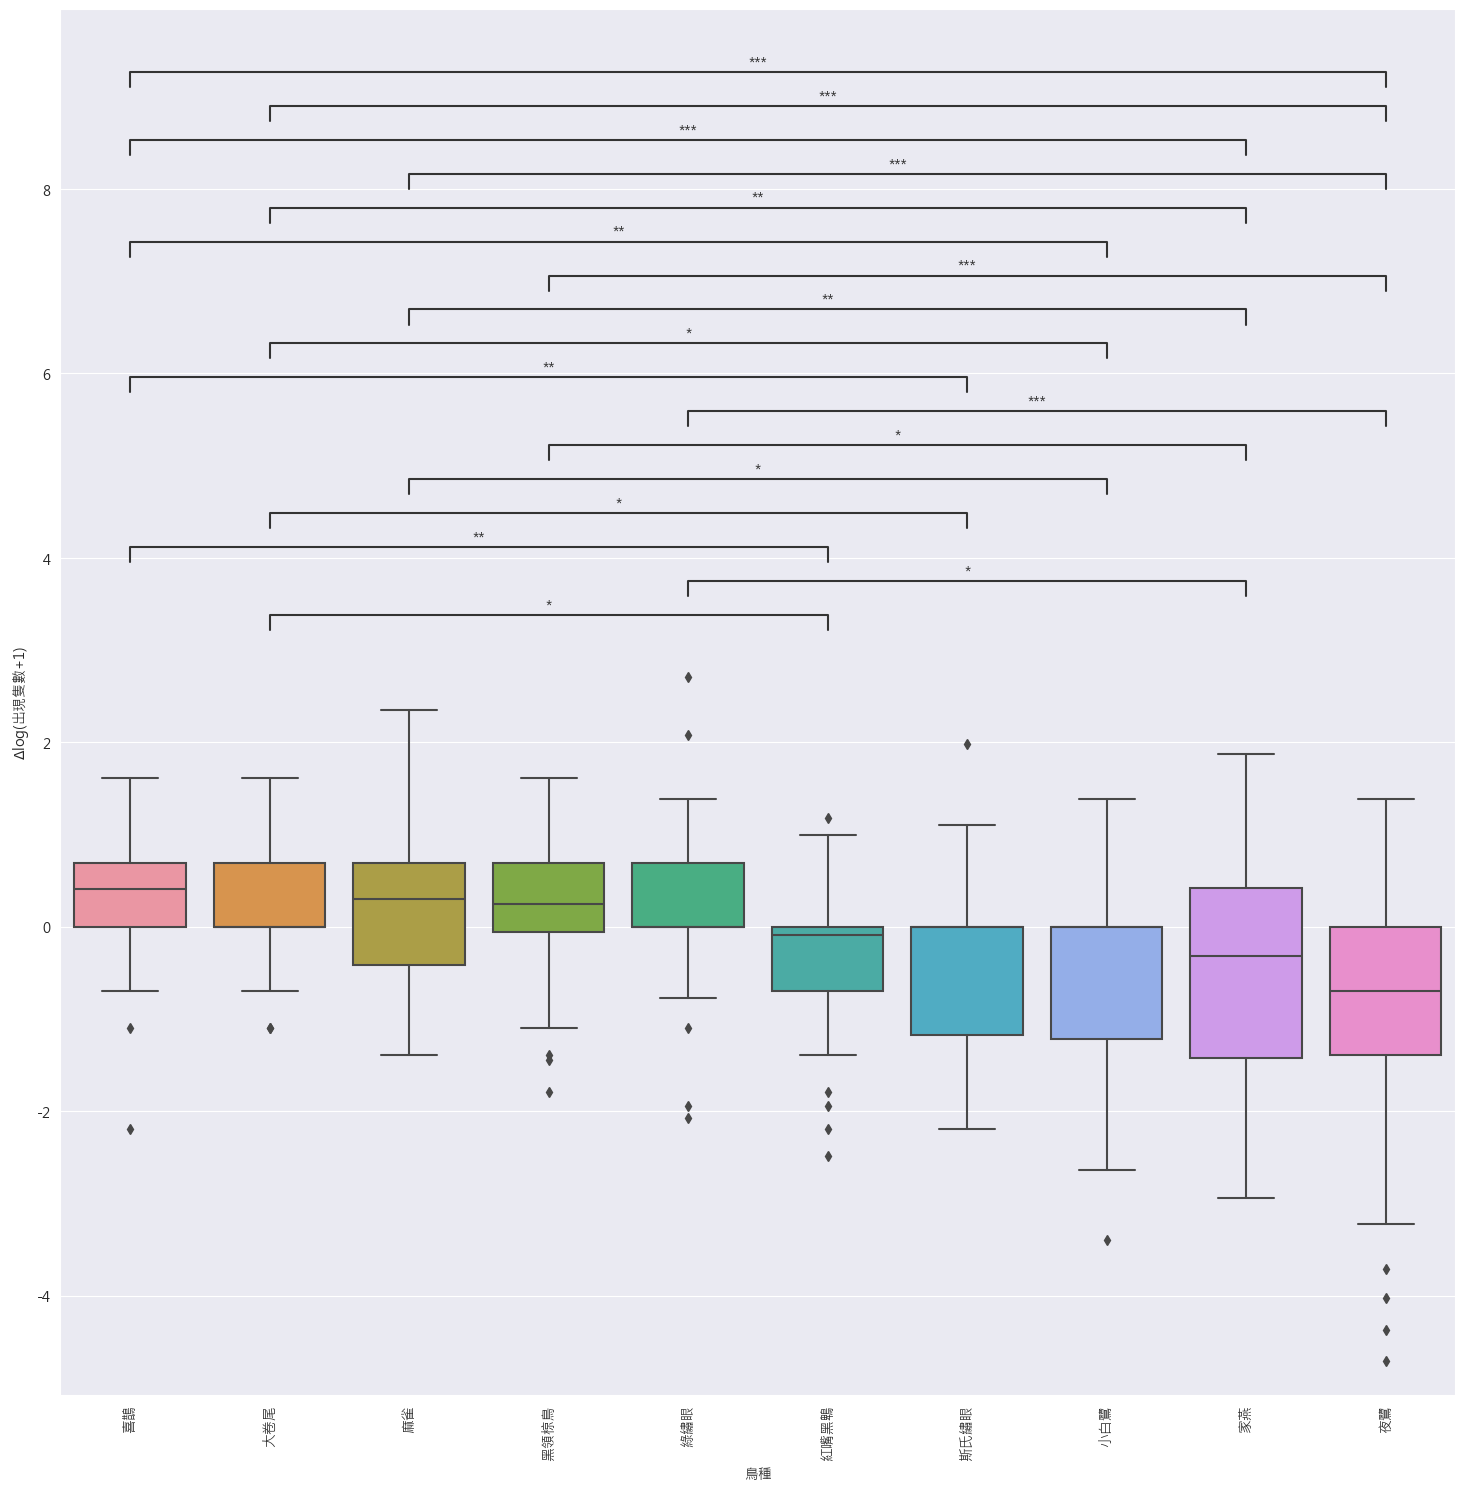

<Figure size 3000x1800 with 0 Axes>

In [236]:
# 选择前五个和后五个物种
selected_species = bird_sorted.index[:5].tolist() + bird_sorted.index[-5:].tolist()

# 创建一个新的 DataFrame，只包含选定的物种
selected_df = cleaned_df[cleaned_df['鳥種'].isin(selected_species)]

plt.figure(figsize=(18, 18))
ax = sns.boxplot(data=selected_df, x="鳥種", y="$\Delta$log(出現隻數+1)", order=selected_species)
plt.xticks(rotation=90)

# 计算 p 值
p_values = [i[1]["value"] for i in molten_df.iterrows() if i[1]["index"] in selected_species and i[1]["variable"] in selected_species]
pairs = [(i[1]["index"], i[1]["variable"]) for i in molten_df.iterrows() if i[1]["index"] in selected_species and i[1]["variable"] in selected_species]

# 只保留 p 值小于 alpha 的组别
significant_pairs = [pair for pair, p in zip(pairs, p_values) if p < alpha]
significant_p_values = [p for p in p_values if p < alpha]

# 创建 Annotator 对象
annotator = Annotator(
    ax, significant_pairs, data=selected_df, x="鳥種", y="$\Delta$log(出現隻數+1)", order=selected_species
)

# 配置 Annotator 对象
annotator.configure(text_format="star", loc="inside")

# 设置 p 值并添加标记
plt.figure(figsize=(30, 18))
annotator.set_pvalues_and_annotate(significant_p_values)
plt.tight_layout()

### box plot t-test

In [229]:
t_test_results_significant

{'夜鷺': (-2.5257806776512264, 0.01540377543763651),
 '蒼鷺': (-4.752973708733049, 0.0007767396629470803)}

c:\Users\harew\hot_folder\Python\bird-_survey\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\harew\hot_folder\Python\bird-_survey\.venv\Lib\site-packages\scipy\stats\_stats_py.py:6951: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


ValueError: Missing x value(s) `"大卷尾", "白鶺鴒", "黑領椋鳥", "家燕", "喜鵲", "夜鷺", "白頭翁", "綠頭鴨(馴化)", "黃鸝", "疣鼻棲鴨", "大白鷺", "綠頭鴨", "翠鳥", "蒼鷺", "樹鵲", "輝椋鳥", "金背鳩", "野鴿", "台灣藍鵲", "珠頸斑鳩", "洋燕", "紅鳩", "小白鷺", "鵲鴝", "白腹秧雞", "家八哥", "綠繡眼", "鴻雁", "五色鳥", "紅嘴黑鵯", "白尾八哥", "黃頭鷺", "麻雀", "八哥", "白面白鶺鴒", "黑天鵝", "紅尾伯勞", "黑冠麻鷺", "紅冠水雞", "綠鳩"` in None (specified in `pairs`) in data

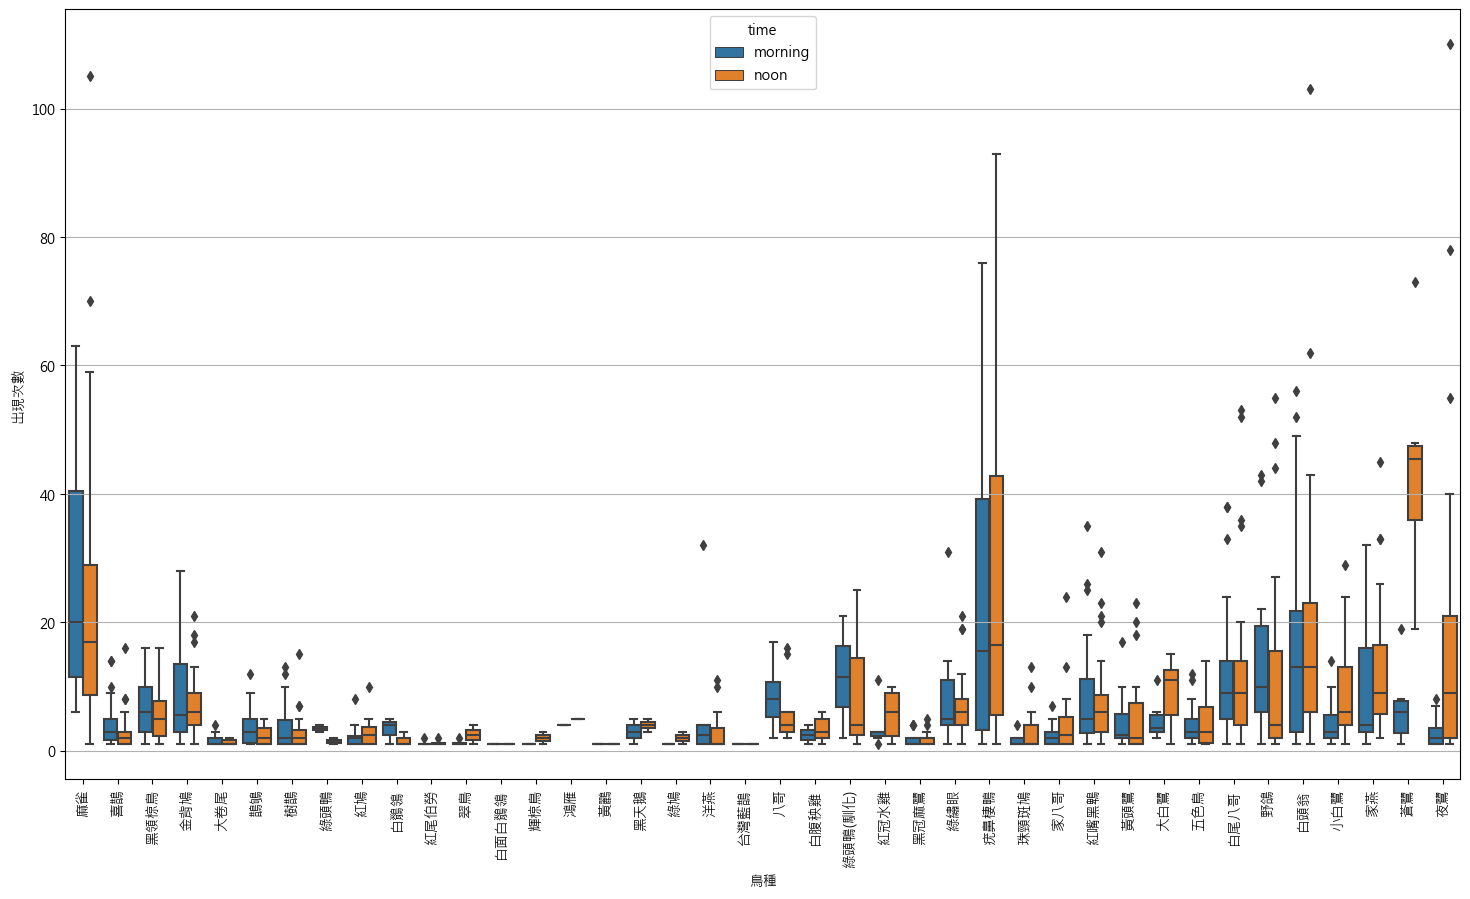

In [90]:
from scipy.stats import ttest_ind
bird_species = df['鳥種'].unique()
morning_df = morning_bird_heatmap.groupby(['鳥種', '樣點編號'])['數量'].sum().reset_index(name='出現次數')
noon_df = noon_bird_heatmap.groupby(['鳥種', '樣點編號'])['數量'].sum().reset_index(name='出現次數')
morning_df['time'] = "morning"
noon_df['time'] = "noon"
# Create a dictionary to store the t-statistics and p-values for each bird species
t_test_results = {}

for x in bird_species:
    morning_counts = morning_df[morning_df['鳥種'] == x]['出現次數']
    noon_counts = noon_df[noon_df['鳥種'] == x]['出現次數']
    t_stat, p_val = ttest_ind(morning_counts, noon_counts)
    t_test_results[x] = (t_stat, p_val)

# Now you can access the t-statistic and p-value for each bird species
# for species, (t_stat, p_val) in t_test_results.items():
#     print(f"Bird Species: {species}, t-statistic: {t_stat}, p-value: {p_val}")
alpha = 0.05
significant_species = [species for species, (t_stat, p_val) in t_test_results.items() if p_val < alpha]
t_test_results_significant = {species: (t_stat, p_val) for species, (t_stat, p_val) in t_test_results.items() if p_val < alpha}
t_test_results_significant
df = pd.merge(morning_df, noon_df, on=['鳥種', '樣點編號'])
df = pd.concat([morning_df, noon_df])
# pair = [(a, b) for (a, b) in zip(df['鳥種'], df['time'])]

# 创建箱线图
bird_sorted = bird_sum.sort_values(ascending=False)
species = bird_sorted.index
plt.figure(figsize=(18, 10))
ax = sns.boxplot(data=df, x='鳥種', y='出現次數', hue='time', order=species)
plt.ylabel('出現次數')
plt.xticks(rotation=90)
ax.yaxis.grid(True)

pair = [(('夜鷺', 'morning'), ('夜鷺', 'noon')), (('蒼鷺', 'morning'), ('蒼鷺','noon'))]
annotator = Annotator(ax, pairs, data=df)
annotator.configure(text_format="star", loc="inside")
p_values = [0.01540377543763651, 0.0007767396629470803]
annotator.set_pvalues_and_annotate(p_values)

ValueError: Missing x value(s) `"白面白鶺鴒", "家燕", "輝椋鳥", "金背鳩", "綠鳩", "白頭翁", "XX八哥", "五色鳥", "黑冠麻鷺", "家八哥", "鵲鴝", "八哥", "樹鵲", "珠頸斑鳩", "黑領椋鳥", "黑天鵝", "斯氏繡眼", "喜鵲", "大白鷺", "紅鳩", "白鶺鴒", "洋燕", "麻雀", "黃鸝", "鴻雁", "紅嘴黑鵯", "紅尾伯勞", "大卷尾", "野鴿", "黃頭鷺", "綠頭鴨(馴化)", "紅冠水雞", "夜鷺", "疣鼻棲鴨", "台灣藍鵲", "綠頭鴨", "白尾八哥", "XX鷺", "XX鳩鴿", "XX燕", "白腹秧雞", "小白鷺", "翠鳥", "綠繡眼", "蒼鷺"` in None (specified in `order`)

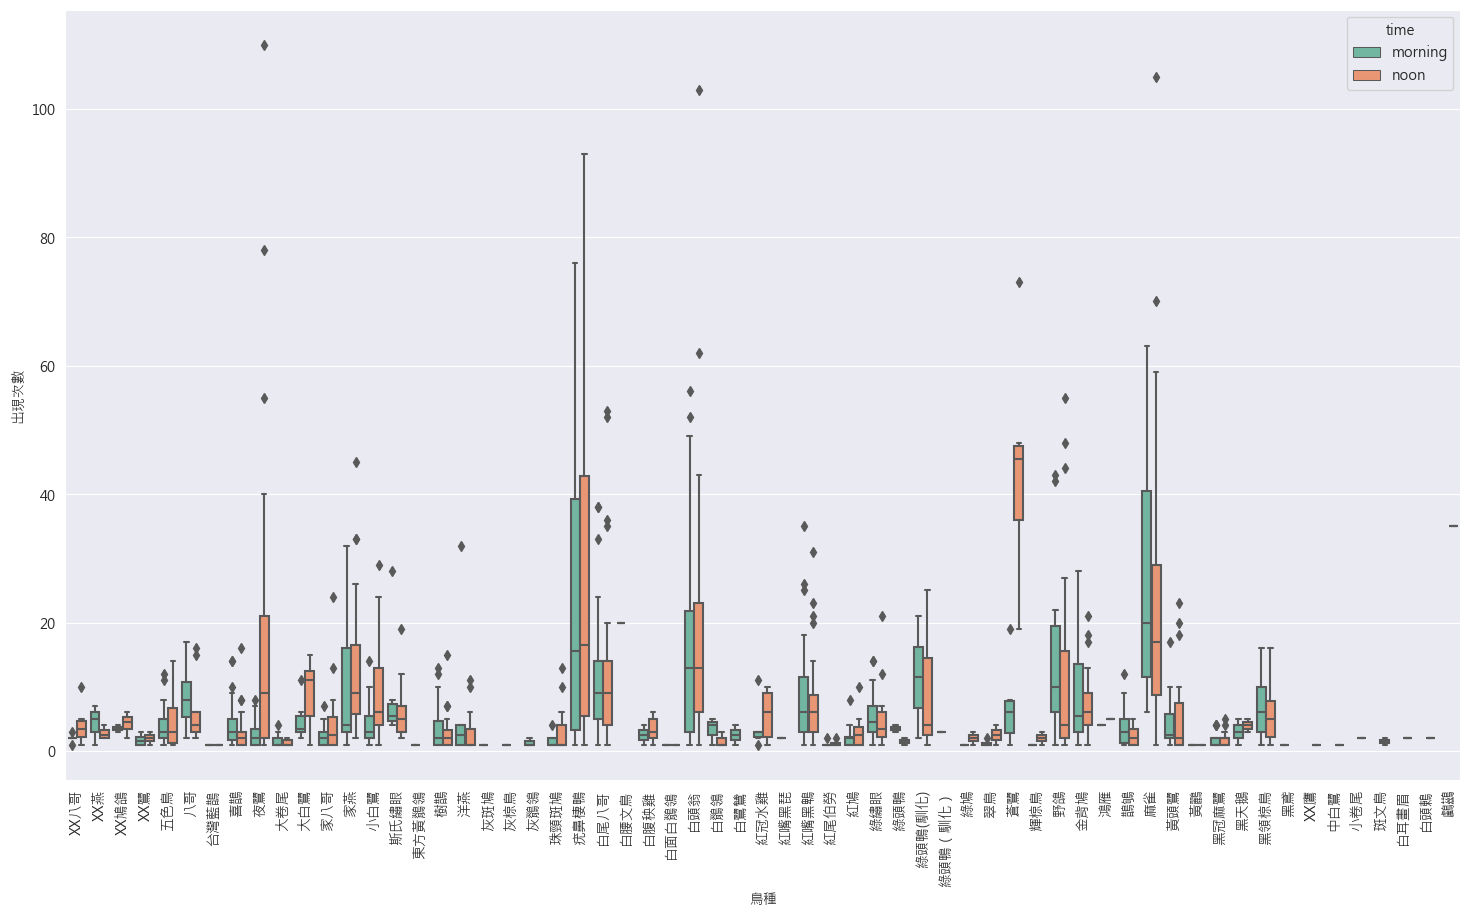

In [213]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

# 合并 morning_df 和 noon_df
df = pd.concat([morning_df, noon_df])

# 创建箱线图
plt.figure(figsize=(18, 10))
ax = sns.boxplot(data=df, x='鳥種', y='出現次數', hue='time')
plt.ylabel('出現次數')
plt.xticks(rotation=90)

# 创建 Annotator 对象



annotator = Annotator(
    ax, pairs, data=df , order=species)
annotator.configure(test="Mann-Whitney", verbose=False, text_format="star", loc="inside")
results = annotator.apply_and_annotate()










# 对每种鳥在早上和下午的出現次數进行配对 t 检验
for bird in df['鳥種'].unique():
    annotator.add_test((bird, 'morning'), (bird, 'noon'), 't-test')

# 添加注释
annotator.annotate()

plt.show()

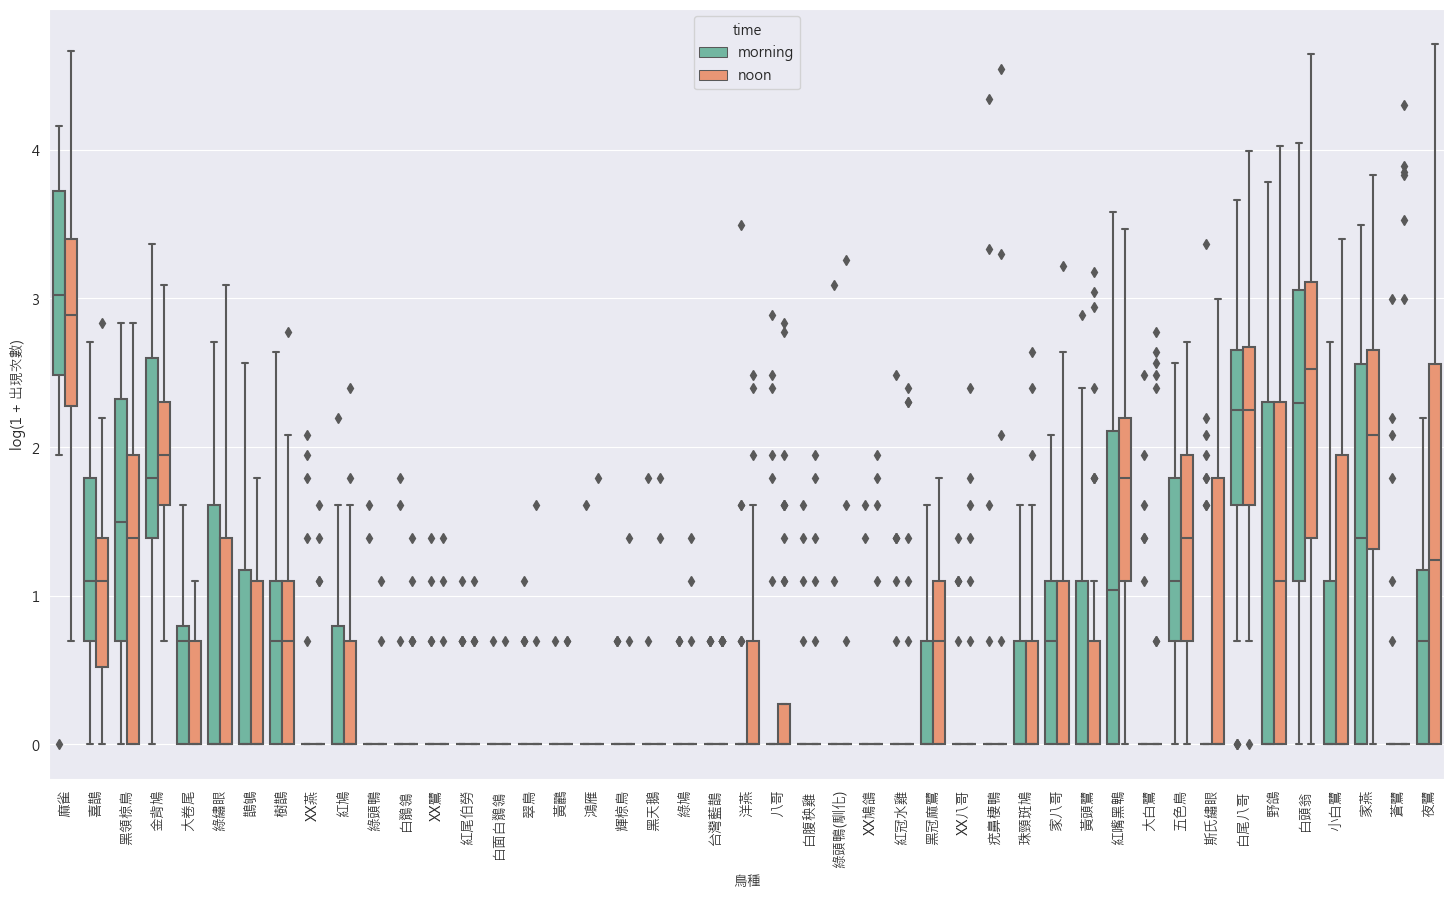

In [142]:
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 morning_df 和 noon_df 是两个 DataFrame，分别包含早上和下午的数据
# 首先，我们需要确保两个 DataFrame 的行是一一对应的
# morning_df = morning_pivot_table.sort_index().sum(axis=0)
# noon_df = noon_pivot_table.sort_index().sum(axis=0)
y_label = "出現次數"
x_label = "鳥種"

# 要沒有 log 版本
morning_df = pd.melt(morning_pivot_table.reset_index(), id_vars='樣點編號', var_name=x_label, value_name=y_label)
noon_df = pd.melt(noon_pivot_table.reset_index(), id_vars='樣點編號', var_name=x_label, value_name=y_label)



# 获取所有的鳥種
all_species = set(morning_df.index).union(noon_df.index)

# 重新索引 DataFrame，确保包含所有的鳥種
morning_df = morning_df.reindex(all_species, fill_value=0)
noon_df = noon_df.reindex(all_species, fill_value=0)
morning_df['time'] = 'morning'
noon_df['time'] = 'noon'

# 进行配对 t 检验
# t_stat, p_value = stats.ttest_rel(morning_df['出現次數'], noon_df['出現次數'])
from statannotations.Annotator import Annotator

# 添加配对 t 检验的注释


# 创建一个新的 DataFrame，包含早上和下午的数据，以及鳥種
df = pd.concat([morning_df, noon_df], axis=0)
# df.columns = ['morning', 'afternoon']



import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 指定默认字体为新宋体。
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题。


df_log1p = df
df_log1p['出現次數'] = df['出現次數'].apply(np.log1p)
# matplotlib.rc('font', family='Microsoft JhengHei')
plt.figure(figsize=(18, 10))
# sns.set_style('darkgrid')
# sns.set_palette('Set2')
ax = sns.boxplot(data=df, x='鳥種', y='出現次數', hue='time', order=species)

plt.ylabel('log(1 + 出現次數)')
plt.xticks(rotation=90)
plt.show()

### 香農 map

In [272]:
'''
A1 25.021292902233817, 121.53479467001416
A2 25.02130464535822, 121.5360711661858
A3 25.021968130061754, 121.53745133717337
B1 25.020735102530956, 121.53537784085398
B2 25.019572522372226, 121.53490482450613
B3 25.01867421674734, 121.53463409232985

'''

def change_coordinate(row):
    x_dict = {'A1':121.53479467001416, 'A2':121.5360711661858, 'A3':121.53745133717337, 'B1':121.53537784085398, 'B2': 121.53490482450613, 'B3':121.53463409232985 }
    y_dict = {'A1':25.02129290223, 'A2':25.02130464536, 'A3':25.02196813006, 'B1':25.02073510253, 'B2':25.01957252237, 'B3':25.01867421675}
    for i in x_dict.keys():
        if row['樣點編號'] == i:
            row['X座標'] = x_dict[i]
            row['Y座標'] = y_dict[i]
    return row

df = df.apply(change_coordinate, axis=1)

In [37]:
def create_map9(df, location, size, color, lat, long, output_filename, map_center=[25.018035617070748, 121.53815856394074], min_radius=8, max_radius=25, distance_factor=2):
    import pandas as pd
    import folium
    from branca.colormap import linear
    from branca.element import Template, MacroElement
    import numpy as np

    # 創建地圖對象，使用黑白主題底圖
    m = folium.Map(location=map_center, zoom_start=15.5, tiles="Cartodb Positron")

    # 創建顏色映射
    colormap = linear.YlOrRd_09.scale(df[color].min(), df[color].max())

    # 計算圓圈大小，使用線性插值
    size_min = df[size].min()
    size_max = df[size].max()
    df['radius'] = df[size].apply(lambda x: min_radius + (max_radius - min_radius) * (x - size_min) / (size_max - size_min))

    # 計算最大圓圈直徑
    max_diameter = max(df['radius']) * 2

    # 將數據點添加到地圖上
    for index, row in df.iterrows():
        # 添加圓圈
        folium.CircleMarker(
            location=[row[lat], row[long]],
            radius=row['radius'],  # 根據線性插值後的大小調整
            color=colormap(row[color]),  # 根據物種數量調整顏色
            fill=True,
            stroke=False,
            fill_opacity=0.8,
            fill_color=colormap(row[color]),
            popup=f"{row[location]}: {row[color]:.2f}種, {row[size]:.2f}個",
        ).add_to(m)

        # 添加地點編號，確保中心對齊
        folium.Marker(
            location=[row[lat], row[long]],
            icon=folium.DivIcon(html=f'''
                <div style="
                    display: flex;
                    justify-content: center;
                    align-items: center;
                    width: {row['radius']*2}px;
                    height: {row['radius']*2}px;
                    font-size: 12pt; 
                    color: white;
                    transform: translate(-50%, -50%);
                    position: absolute;
                    top: 50%;
                    left: 50%;">
                    {row["樣點編號"]}
                </div>
            ''')
        ).add_to(m)
    # 在地圖上添加顏色圖例
    colormap.caption = color
    colormap.add_to(m)
    # 根據數據選擇適當的圓圈大小
    sizes = df[size].quantile([0.2, 0.4, 0.6, 0.8, 1.0]).apply(lambda x: min_radius + (max_radius - min_radius) * (x - size_min) / (size_max - size_min)).values

    # 計算每個圓圈之間的距離，確保它們不重疊
    distances = [0]  # 第一個圓圈的位置
    for i in range(1, len(sizes)):
        distances.append(distances[-1] + (sizes[i-1] + sizes[i]) * distance_factor + 10)  # 確保間距足夠大

    # 計算模板的最大寬度
    max_width = 60 + distances[-1] + sizes[-1] * 2 + 20

    template = f"""
    {{% macro html(this, kwargs) %}}
    <div style="
        position: fixed;
        top: 40px; 
        right: 100px; 
        width: {max_width}px;  <!-- 動態調整寬度 -->
        height: 120px;
        z-index:10000;  <!-- 提高 z-index -->
        font-size:14px;
        ">
        <svg width="{max_width}" height="150">  <!-- 動態調整 SVG 的寬度 -->
        <text x="60" y="30" font-size="14" >{size}</text>  <!-- 將文字向右移動 -->
        <circle cx="{60 + distances[4]}" cy="60" r="{sizes[4]}" stroke="black" stroke-width="0" fill="gray" />
        <text x="{60 + distances[4] + sizes[4] + 5}" y="65" font-size="12" >{df[size].quantile(1.0):.2f}</text>
        <circle cx="{60 + distances[3]}" cy="60" r="{sizes[3]}" stroke="black" stroke-width="0" fill="gray" />
        <text x="{60 + distances[3] + sizes[3] + 5}" y="65" font-size="12" >{df[size].quantile(0.8):.2f}</text>
        <circle cx="{60 + distances[2]}" cy="60" r="{sizes[2]}" stroke="black" stroke-width="0" fill="gray" />
        <text x="{60 + distances[2] + sizes[2] + 5}" y="65" font-size="12" >{df[size].quantile(0.6):.2f}</text>
        <circle cx="{60 + distances[1]}" cy="60" r="{sizes[1]}" stroke="black" stroke-width="0" fill="gray" />
        <text x="{60 + distances[1] + sizes[1] + 5}" y="65" font-size="12" >{df[size].quantile(0.4):.2f}</text>
        <circle cx="{60 + distances[0]}" cy="60" r="{sizes[0]}" stroke="black" stroke-width="0" fill="gray" />
        <text x="{60 + distances[0] + sizes[0] + 5}" y="65" font-size="12" >{df[size].quantile(0.2):.2f}</text>
        </svg>
    </div>
    <div style="
        position: fixed;
        top: 50px;
        right: 50px;
        width: {max_width}px;  <!-- 動態調整寬度 -->
        height: 80px;
        z-index:9999;  <!-- 降低 z-index -->
        font-size:14px;
        background-color: #ffffff;
        filter: blur(3px);
        -webkit-filter: blur(3px);
        opacity: 0.9;
        ">
    </div>
    {{% endmacro %}}
    """

    # 創建MacroElement實例並添加到地圖中
    macro = MacroElement()
    macro._template = Template(template)

    m.get_root().add_child(macro)

    # 保存或顯示地圖
    m.save(output_filename)
    return m


In [38]:
import numpy as np

def shannon_diversity(df):
    # Calculate the total number of each bird species
    birdnum_perSpecies = df.groupby('鳥種')['數量'].sum()

    # Calculate the total number of birds
    total_birds = birdnum_perSpecies.sum()

    # Calculate the relative abundance of each bird species
    relative_abundance = birdnum_perSpecies / total_birds

    # Calculate the Shannon Diversity Index
    shannon_index = -np.sum(relative_abundance * np.log(relative_abundance))
    return shannon_index

In [39]:
# # Group the DataFrame by place and calculate the Shannon Diversity Index for each place
# shannon_indices = pd.DataFrame({
#     '樣點編號': place,
#     '香農多樣性指數': [shannon_diversity(df[df['樣點編號'] == i]) for i in place],
#     '物種均一度': [shannon_diversity(df[df['樣點編號'] == i]) / np.log(df[df['樣點編號'] == i]['鳥種'].nunique()) for i in place]
# })
# shannon_indices

# coordinates = df.groupby('樣點編號')[['X座標', 'Y座標']].first()
# coordinates

# shannon_indices = shannon_indices.merge(coordinates, on='樣點編號')
# shannon_indices

# create_map8(df=shannon_indices, location='樣點編號', size='物種均一度', color='香農多樣性指數', lat='Y座標', long='X座標', output_filename='shannon_diversity.html')

In [42]:


coordinates = df.groupby('樣點編號')[['X座標', 'Y座標']].first()

df_afternoon = df[df['開始時間\n（時）'] >= 12]
df_mornong = df[df['開始時間\n（時）'] < 12]
# Group the DataFrame by place and calculate the Shannon Diversity Index for each place
def get_shannon_indices(df, shannon_diversity, coordinates, place):
    shannon_indices = pd.DataFrame({
        '樣點編號': place,
        '香農多樣性指數': [shannon_diversity(df[df['樣點編號'] == i]) for i in place],
        '物種均一度': [shannon_diversity(df[df['樣點編號'] == i]) / np.log(df[df['樣點編號'] == i]['鳥種'].nunique()) for i in place]
    })
    shannon_indices = shannon_indices.merge(coordinates, on='樣點編號')
    return shannon_indices

shannon_indices = get_shannon_indices(df, shannon_diversity, coordinates, place)


shannon_indices

create_map9(df=shannon_indices, location='樣點編號', size='物種均一度', color='香農多樣性指數', lat='Y座標', long='X座標', output_filename='shannon_diversity.html')

In [523]:
df_grouped = df.groupby(['樣點編號', '鳥種'])['數量'].sum().unstack().fillna(0)
df_grouped

鳥種,XX八哥,XX燕,XX鳩鴿,XX鷺,xx燕,xx鷺,五色鳥,八哥,台灣藍鵲,喜鵲,...,翠鳥,野鴿,金背鳩,鵲鴝,麻雀,黃頭鶺鴒,黃頭鷺,黃鸝,黑冠麻鷺,黑領椋鳥
樣點編號,,,,,,,,,,,,,,,,,,,,,
G1,3.0,2.0,8.0,1.0,0.0,0.0,17.0,0.0,0.0,16.0,...,0.0,2.0,14.0,8.0,27.0,0.0,1.0,0.0,2.0,14.0
G2,4.0,0.0,5.0,0.0,0.0,0.0,7.0,0.0,0.0,16.0,...,0.0,27.0,14.0,17.0,19.0,0.0,1.0,1.0,8.0,18.0
G3,3.0,2.0,0.0,3.0,1.0,1.0,9.0,2.0,1.0,2.0,...,1.0,1.0,19.0,7.0,67.0,0.0,0.0,1.0,3.0,25.0
H1,12.0,5.0,6.0,0.0,0.0,0.0,12.0,0.0,0.0,23.0,...,0.0,57.0,11.0,2.0,121.0,1.0,0.0,0.0,0.0,21.0
H2,3.0,10.0,0.0,1.0,0.0,2.0,24.0,0.0,0.0,1.0,...,5.0,82.0,20.0,5.0,15.0,0.0,0.0,0.0,4.0,13.0
H3,5.0,0.0,5.0,4.0,0.0,0.0,4.0,0.0,0.0,6.0,...,1.0,6.0,26.0,0.0,13.0,0.0,0.0,0.0,1.0,15.0


### PCA

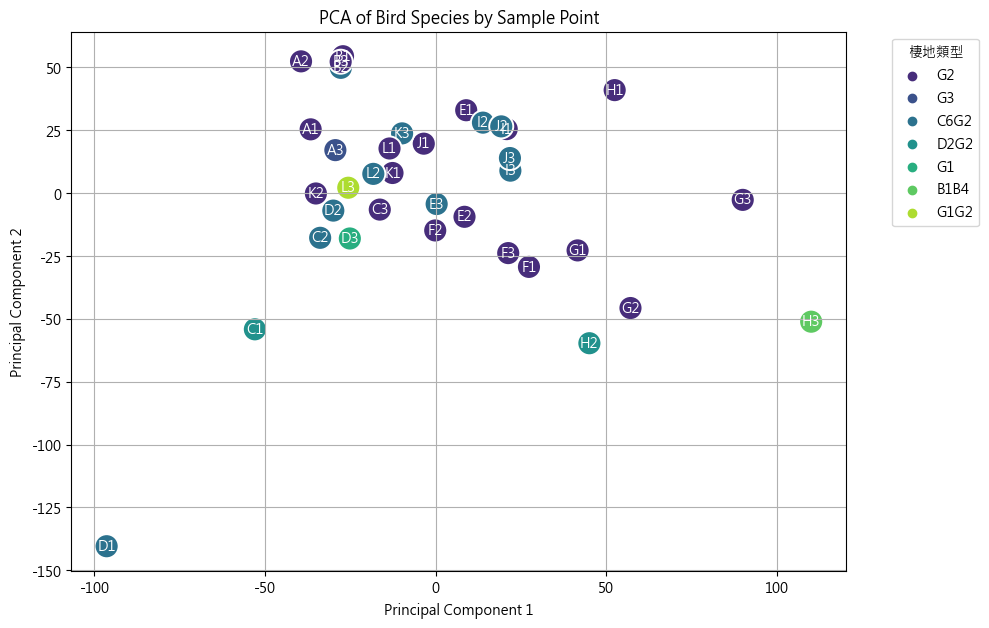

In [43]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
import numpy as np
# place_catagory = {'G1':'G2', 'G2':'G2', 'G3':'G2', 'H1':'G2', 'H2':'D2G2', 'H3':'B1B4', }
place_catagory = {'G1':'G2', 'G2':'G2', 'G3':'G2', 'H1':'G2', 'H2':'D2G2', 'H3':'B1B4',
                   'A1':'G2', 'A2':'G2', 'A3':'G3' , 'C1':'D2G2' , 'C2':'C6G2' , 'C3':'G2' , 
                   'B1':'G2' , 'B2':'C6G2' , 'B3':'G2' , 'D1':'C6G2' , 'D2':'C6G2' , 'D3':'G1' , 
                   'E1':'G2' , 'E2':'G2' , 'E3':'C6G2' , 'F1':'G2' , 'F2':'G2' , 'F3':'G2' , 
                   'I1':'G2' , 'I2':'C6G2' , 'I3':'C6G2' , 'J1':'G2' , 'J2':'C6G2' , 'J3':'C6G2' , 
                   'K1':'G2' , 'K2':'G2' , 'K3':'C6G2' , 'L1':'G2' , 'L2':'C6G2' , 'L3':'G1G2' }
df_place_catagory = pd.DataFrame({'樣點編號': list(place_catagory.keys()), '棲地類型': list(place_catagory.values())})
df_grouped = df.groupby(['樣點編號', '鳥種'])['數量'].sum().unstack().fillna(0)

# PCA分析
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_grouped)

# KMeans聚类
kmeans = KMeans(n_clusters=7)  
clusters = kmeans.fit_predict(principal_components)

# 将PCA结果转换为数据框
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['樣點編號'] = df_grouped.index
pca_df = pca_df.merge(df_place_catagory, on='樣點編號')
pca_df['Cluster'] = clusters


# 绘制PCA结果
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue='棲地類型', palette='viridis', s=300, )
for i in range(pca_df.shape[0]):
    plt.text(pca_df.PC1[i], pca_df.PC2[i], pca_df['樣點編號'][i], horizontalalignment='center', verticalalignment='center', color = 'white')
plt.title('PCA of Bird Species by Sample Point')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='棲地類型', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [75]:
def get_key(my_dict, val):
    for key, value in my_dict.items():
        if val == value:
            print(key, end="、", sep="、")

get_key(place_catagory, 'G1G2')
len(place_catagory)

L3、

36

#### PCA 樣區類型

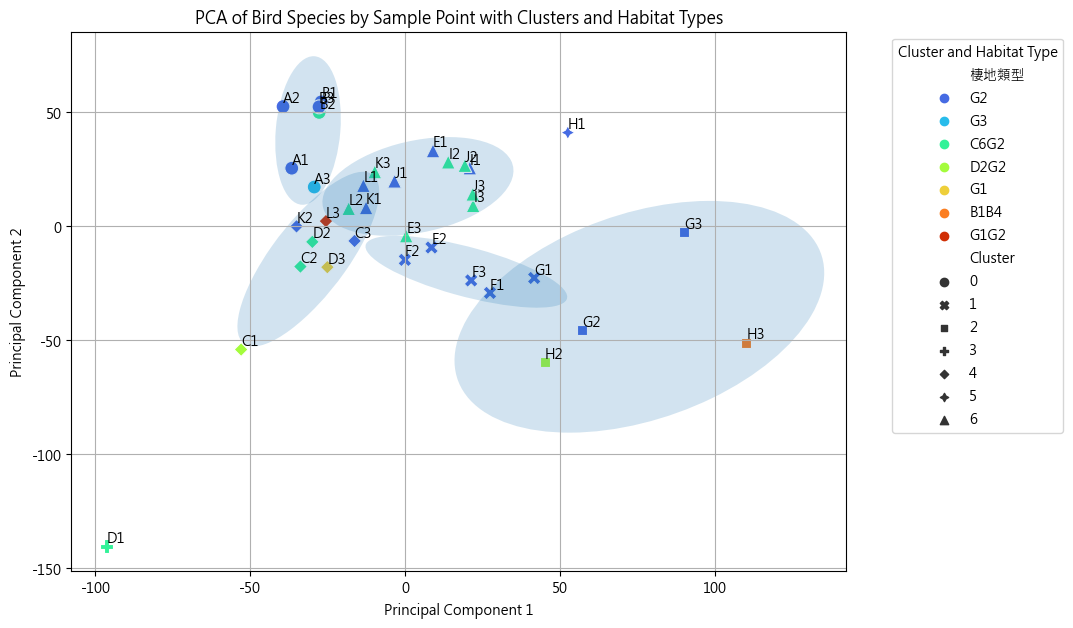

In [56]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
import numpy as np
place_catagory = {'G1':'G2', 'G2':'G2', 'G3':'G2', 'H1':'G2', 'H2':'D2G2', 'H3':'B1B4',
                   'A1':'G2', 'A2':'G2', 'A3':'G3' , 'C1':'D2G2' , 'C2':'C6G2' , 'C3':'G2' , 
                   'B1':'G2' , 'B2':'C6G2' , 'B3':'G2' , 'D1':'C6G2' , 'D2':'C6G2' , 'D3':'G1' , 
                   'E1':'G2' , 'E2':'G2' , 'E3':'C6G2' , 'F1':'G2' , 'F2':'G2' , 'F3':'G2' , 
                   'I1':'G2' , 'I2':'C6G2' , 'I3':'C6G2' , 'J1':'G2' , 'J2':'C6G2' , 'J3':'C6G2' , 
                   'K1':'G2' , 'K2':'G2' , 'K3':'C6G2' , 'L1':'G2' , 'L2':'C6G2' , 'L3':'G1G2' }
df_place_catagory = pd.DataFrame({'樣點編號': list(place_catagory.keys()), '棲地類型': list(place_catagory.values())})
df_grouped = df.groupby(['樣點編號', '鳥種'])['數量'].sum().unstack().fillna(0)

# PCA分析
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_grouped)

# KMeans聚类
kmeans = KMeans(n_clusters=7)  # 假设分成3个群
clusters = kmeans.fit_predict(principal_components)

# 将PCA结果转换为数据框
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['樣點編號'] = df_grouped.index
pca_df = pca_df.merge(df_place_catagory, on='樣點編號')
pca_df['Cluster'] = clusters


# 绘制PCA结果

plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', style='Cluster', hue='棲地類型', data=pca_df, palette='turbo', s=100, legend='full')

# 绘制椭圆圈出聚类
for cluster in np.unique(clusters):
    cluster_points = pca_df[pca_df['Cluster'] == cluster]
    if len(cluster_points) > 1:  # 至少要有两个点才能计算协方差
        cov = np.cov(cluster_points[['PC1', 'PC2']].values.T)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        for nsig in range(2, 3):  # 绘制1、2、3个标准差范围的椭圆
            width, height = 2 * nsig * np.sqrt(eigenvalues)
            ellipse = Ellipse(xy=np.mean(cluster_points[['PC1', 'PC2']], axis=0),
                              width=width, height=height,
                              angle=angle, alpha=0.2)
            plt.gca().add_patch(ellipse)

for i in range(pca_df.shape[0]):
    plt.text(pca_df.PC1[i], pca_df.PC2[i], pca_df['樣點編號'][i], horizontalalignment='left', verticalalignment='bottom')

plt.title('PCA of Bird Species by Sample Point with Clusters and Habitat Types')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster and Habitat Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

#### PCA 調查組別

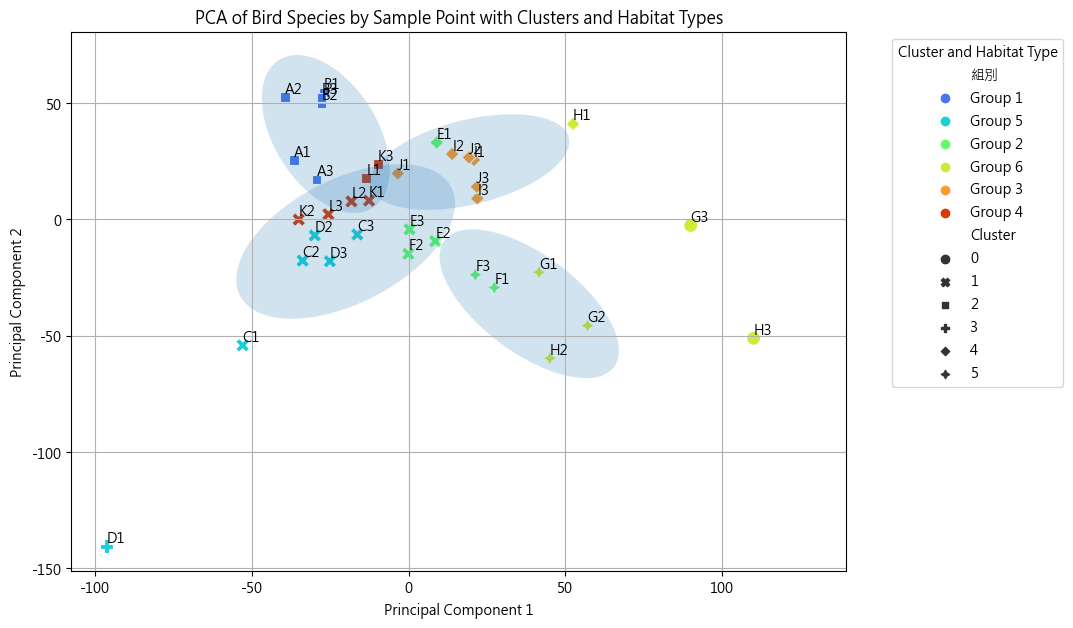

In [83]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
import numpy as np
place_catagory = {'G1':'Group 6', 'G2':'Group 6', 'G3':'Group 6', 'H1':'Group 6', 'H2':'Group 6', 'H3':'Group 6',
                   'A1':'Group 1', 'A2':'Group 1', 'A3':'Group 1' , 'C1':'Group 5' , 'C2':'Group 5' , 'C3':'Group 5' , 
                   'B1':'Group 1' , 'B2':'Group 1' , 'B3':'Group 1' , 'D1':'Group 5' , 'D2':'Group 5' , 'D3':'Group 5' , 
                   'E1':'Group 2' , 'E2':'Group 2' , 'E3':'Group 2' , 'F1':'Group 2' , 'F2':'Group 2' , 'F3':'Group 2' , 
                   'I1':'Group 3' , 'I2':'Group 3' , 'I3':'Group 3' , 'J1':'Group 3' , 'J2':'Group 3' , 'J3':'Group 3' , 
                   'K1':'Group 4' , 'K2':'Group 4' , 'K3':'Group 4' , 'L1':'Group 4' , 'L2':'Group 4' , 'L3':'Group 4' }
df_group_catagory = pd.DataFrame({'樣點編號': list(place_catagory.keys()), '組別': list(place_catagory.values())})
df_grouped = df.groupby(['樣點編號', '鳥種'])['數量'].sum().unstack().fillna(0)

# PCA分析
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_grouped)

# KMeans聚类
kmeans = KMeans(n_clusters=6)  # 假设分成3个群
clusters = kmeans.fit_predict(principal_components)

# 将PCA结果转换为数据框
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['樣點編號'] = df_grouped.index
pca_df = pca_df.merge(df_group_catagory, on='樣點編號')
pca_df['Cluster'] = clusters


# 绘制PCA结果

plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', style='Cluster', hue='組別', data=pca_df, palette='turbo', s=100, legend='full')

# 绘制椭圆圈出聚类
for cluster in np.unique(clusters):
    cluster_points = pca_df[pca_df['Cluster'] == cluster]
    if len(cluster_points) > 1:  # 至少要有两个点才能计算协方差
        cov = np.cov(cluster_points[['PC1', 'PC2']].values.T)
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
        for nsig in range(2, 3):  # 绘制1、2、3个标准差范围的椭圆
            width, height = 2 * nsig * np.sqrt(eigenvalues)
            ellipse = Ellipse(xy=np.mean(cluster_points[['PC1', 'PC2']], axis=0),
                              width=width, height=height,
                              angle=angle, alpha=0.2)
            plt.gca().add_patch(ellipse)

for i in range(pca_df.shape[0]):
    plt.text(pca_df.PC1[i], pca_df.PC2[i], pca_df['樣點編號'][i], horizontalalignment='left', verticalalignment='bottom')

plt.title('PCA of Bird Species by Sample Point with Clusters and Habitat Types')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster and Habitat Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

### bird familly

In [11]:
import pandas as pd
df_bird_data = pd.read_csv('./data/bird_species_info.csv')
len(df_bird_data['科名'].unique())
df_bird_data['科名'].unique()

array(['鳩鴿', '椋鳥', '鵯', '雀', '鷺', '畫眉', '燕', '梅花雀', '鴉', '卷尾', '擬啄木',
       '鶺鴒', '繡眼', '鶲', '鷹', '伯勞', '鶇', '翠鳥', '秧雞', '黃鸝', '雁鴨', '鸕鶿'],
      dtype=object)